# **Test Set Scores**

In [8]:
import os
import sys
import statistics
import subprocess
import warnings; warnings.filterwarnings('ignore')
import collections

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

utils_path = os.path.join(os.getcwd(), '..', '..', '..')
if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

from notebooks.src.utils import plots, constants
from src.domain.evaluation import metrics

In [9]:
CACHE = True
TEST_OUTPUTS_DIR = os.path.join(constants.INSPECTED_DATA_FOLDER, 'test_set')
GOOGLE_TRANSLATIONS_DIR = os.path.join(TEST_OUTPUTS_DIR, 'google')
GOOGLE_TEST_GN_ES = os.path.join(GOOGLE_TRANSLATIONS_DIR, 'test_translation_gn_es.txt')
GOOGLE_TEST_ES_GN = os.path.join(GOOGLE_TRANSLATIONS_DIR, 'test_translation_es_gn.txt')
JOJAJOVAI_DIR = os.path.join(constants.INSPECTED_DATA_FOLDER, '..', '..', '..', 'artifacts', 'data', 'raw', 'jojajovai_all.csv')
RESULTS_DIR = constants.RESULTS_DATA_FOLDER

In [10]:
architectures = ['transformer', 's2s']
directions = ['gn_es', 'es_gn']
pretraining_options = ['pretraining', 'without_pretraining']
hyperparameter_tuning_options = ['adjusted', 'default']
corpus_names = ['grammar', 'ancora', 'bible', 'merged']
NOT_PRETRAINED_CORPUS = 'not_pretrained'

real_test_set_template = os.path.join(constants.PROJECT_DIR, 'artifacts', 'data', 'test', 'test.{trg}')
scorer_script = os.path.join(constants.PROJECT_DIR, 'scripts', 'validate', 'score.py')
score_types = ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf']

In [11]:
TEST_SET_CSV_FILEPATH = os.path.join(RESULTS_DIR, 'test_set_metrics.csv')
exists_test_set_csv = os.path.isfile(TEST_SET_CSV_FILEPATH)

if CACHE and exists_test_set_csv:
    df = pd.read_csv(TEST_SET_CSV_FILEPATH)

## **1. Corpus Metrics**

### **1.1. Data Fetching (Cached)**

In [59]:
if not CACHE or not exists_test_set_csv:
    model_output = {
        architecture: {
            direction: {
                pretraining_option: {
                    hyperparameter_tuning_option: {
                        corpus_name: None for corpus_name in corpus_names + [NOT_PRETRAINED_CORPUS]
                    } for hyperparameter_tuning_option in hyperparameter_tuning_options
                } for pretraining_option in pretraining_options
            } for direction in directions
        } for architecture in architectures
    }

    def get_substring(name: str, substrings: list[str]):
        for substring in substrings:
            if substring in name:
                return substring
        return None

    for pretraining_options_dirname in os.listdir(TEST_OUTPUTS_DIR):
        pretraining_options_dir = os.path.join(TEST_OUTPUTS_DIR, pretraining_options_dirname)
        for hyperparameter_tuning_options_dirname in os.listdir(pretraining_options_dir):
            if hyperparameter_tuning_options_dirname not in hyperparameter_tuning_options:
                continue

            hyperparameter_options_dir = os.path.join(pretraining_options_dir, hyperparameter_tuning_options_dirname)
            for output_filename in os.listdir(hyperparameter_options_dir):
                file_architecture = get_substring(output_filename, architectures)
                file_direction = get_substring(output_filename, directions)
                corpus_name = get_substring(output_filename, corpus_names) if pretraining_options_dirname != 'without_pretraining' else NOT_PRETRAINED_CORPUS
                print(file_architecture, file_direction, corpus_name, pretraining_options_dirname, output_filename)
                output_filepath = os.path.join(hyperparameter_options_dir, output_filename)
                print(output_filepath, end='\n\n')
                model_output[file_architecture][file_direction][pretraining_options_dirname][hyperparameter_tuning_options_dirname][corpus_name] = output_filepath


In [60]:
if not CACHE or not exists_test_set_csv:
    data_list = []

    for architecture, dir_dict in model_output.items():
        for direction, pretrain_dict in dir_dict.items():
            for pretrain_option, hyper_dict in pretrain_dict.items():
                for hyper_option, corpora_dir in hyper_dict.items():
                    for corpus_name, filepath in corpora_dir.items():
                        
                        if filepath is None:
                            continue
                        
                        data_list.append({'architecture': architecture,
                                          'pretraining_corpus': corpus_name,
                                          'source': direction.split('_')[0],
                                          'target': direction.split('_')[1],
                                          'pretraining_option': pretrain_option,
                                          'hyperparameter_tuning_option': hyper_option,
                                          'filepath': filepath})

    df = pd.DataFrame(data_list)
    df

In [61]:
if  not CACHE or not exists_test_set_csv:
    scores = {metric: [] for metric in score_types}

    def get_score(filepath: str, target: str, metric: str):
        current_reference_file = real_test_set_template.format(trg=target)
        res = subprocess.run(['python', scorer_script, 
                            '--reference_file', current_reference_file, 
                            '--translation_file', filepath, 
                            '--score', metric], 
                            capture_output=True)
        output = res.stdout.decode('utf-8')
        return float(output)

In [62]:
if  not CACHE or not exists_test_set_csv:
    for metric in score_types:
        for i, row in df.iterrows():
            filepath = row['filepath']
            current_reference_file = real_test_set_template.format(trg=row['target'])
            output = get_score(filepath, row['target'], metric)
            print(f'{os.path.basename(filepath)} {metric}: {output}')
            scores[metric].append(float(output))
            
        df[metric] = scores[metric]

In [63]:
if  not CACHE or not exists_test_set_csv:
    google_gn_es_bleu = get_score(GOOGLE_TEST_GN_ES, 'es', 'sacrebleu_corpus_bleu')
    google_gn_es_chrf = get_score(GOOGLE_TEST_GN_ES, 'es', 'sacrebleu_corpus_chrf')
    google_es_gn_bleu = get_score(GOOGLE_TEST_ES_GN, 'gn', 'sacrebleu_corpus_bleu')
    google_es_gn_chrf = get_score(GOOGLE_TEST_ES_GN, 'gn', 'sacrebleu_corpus_chrf')

In [64]:
if  not CACHE or not exists_test_set_csv:
  google_df = pd.DataFrame([{'architecture': 'google',
                              'source': 'gn',
                              'target': 'es',
                              'pretraining_option': 'without_pretraining',
                              'hyperparameter_tuning_option': 'default',
                              'sacrebleu_corpus_bleu': google_gn_es_bleu,
                              'sacrebleu_corpus_chrf': google_gn_es_chrf}, 
                            {'architecture': 'google',
                            'source': 'es',
                            'target': 'gn',
                            'pretraining_option': 'without_pretraining',
                            'hyperparameter_tuning_option': 'default',
                            'sacrebleu_corpus_bleu': google_es_gn_bleu,
                            'sacrebleu_corpus_chrf': google_es_gn_chrf}])

  df = pd.concat([df, google_df], axis=0)

### **1.2. Global Scores**

In [145]:
df['model_id'] = df['source'] + '-' + df['target'] + '-' + df['architecture'] + '-' + df['hyperparameter_tuning_option'] + '-' + df['pretraining_option'] + '-' + df['pretraining_corpus'].astype(str)
df['model_id'] = df['model_id'].astype('category')
df = df.sort_values(by=['source', 'sacrebleu_corpus_bleu'], ascending=False)
df

architecture                                          filelines  \
0        google  [Ahora le toca a Cartes, La movilización ciuda...   
1           s2s  [Ahora Cartes es el turno, La movilización ciu...   
2           s2s  [Ahora Cartes es turno, La movilización ciudad...   
3           s2s  [Ahora es el turno de Cartes, La movilización ...   
4           s2s  [Ahora de Cartes, La movilización ciudadana se...   
5           s2s  [Ahora es el turno de Cartes, La movilización ...   
6   transformer  [Ahora Cartes es turno, La movilización ciudad...   
7           s2s  [Ahora Cartes y Cartes, La movilización ciudad...   
8   transformer  [Ahora Cartes, La movilización ciudadana se co...   
9   transformer  [Ahora Cartes, La movilización ciudadana se re...   
10          s2s  [Confirmar aún, La movilización ciudadana de l...   
11          s2s  [En un ser Cartes, La movilización ciudadana s...   
12          s2s  [Solamente tras el amor, La movilización ciuda...   
13  transformer  [Ahora es Cartes, La movilización se reunieron...   
14  transformer  [Ahora Cartes:, La movilización ciudadana en e...   
15  transformer  [Ahora turno, La movilización ciudadana ciudad...   
16  transformer  [Ahora Cartes, La movilización ser parte de la...   
17  transformer  [Ahora ahora turno., Movilización de la invest...   
18  transformer  [Ahora alega más Cartes, La movilización ciuda...   
19  transformer  [Actualmente, El presidente Horacio Cartes se ...   
20          s2s  [Ahora quiere tres días., En la tarde de este ...   
21          s2s  [Ko'ágã oguahê turno Cartes-pe, Movilización c...   
22          s2s  [Ko'ágã oguahê turno Cartes-pe, Movilización c...   
23          s2s  [Ko'ágã oguahê turno Cartes-pe, Movilización h...   
24          s2s  [Ko'ágã oguahê turno Cartes-pe, Movilización c...   
25          s2s  [Ko'ágã turno Cartes renuncia, Movilización ci...   
26  transformer  [Ko'ágã oguahê turno Cartes, Movilización ciud...   
27       google  [Ko'ágã ha'e Cartes turno, Movilización ciudad...   
28  transformer  [Ko'ágã turno Cartes-pe, Movilización ciudadan...   
29  transformer  [Ko'ágã oguahê Cartes turno, Movilización ciud...   
30  transformer  [Ko'ágã niko turno Cartes-pe, Movilización ciu...   
31          s2s  [Ko'ágã ha'e turno Cartes-pe, Movilización ciu...   
32          s2s  [Ko'ágã oguahê turno Cartes-gui, Movilización ...   
33  transformer  [Ko'ágã turno Cartes, Movilización ciudadana o...   
34          s2s  [Ko'ágã oguahê turno Cartes-pe, Movilización c...   
35  transformer  [Ko'ágã oguahê turno Cartes-pe, Movilización k...   
36  transformer  [Ko'ágã oguahê turno Cartes-pe, Movilización o...   
37  transformer  [Ko'ágã oguahê Cartes, Movilización ciudadana ...   
38  transformer  [Ko'ágã oguahê turno Cartes-pe, Expo ohupytýva...   
39  transformer  [Ko'ágã Cartes ha'e Cartes, Movilización ombot...   
40          s2s  [Ko'ágã oguahê turno Cartes-pe, Cuevas ome'ê i...   
41          s2s  [Ko'ágã Cartes róga rovái., Congreso oipyhy Co...   

                                             filepath  \
0                                                 NaN   
1   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
2   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
3   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
4   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
5   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
6   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
7   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
8   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
9   f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
10  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
11  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
12  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
13  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
14  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
15  f:\my_year2023\PLN\code\MARIAN\notebooks\src\u...   
16  f:\my_year2023\PLN\

In [144]:
def plot_global_scores(df: pd.DataFrame):
    fig, axes = plt.subplots(2, 1, figsize=(12, 40))

    sorted_df = df.sort_values(['target', 'sacrebleu_corpus_bleu'], ascending=False)

    ax1 = sns.barplot(ax=axes[0], 
                y='model_id', 
                x='sacrebleu_corpus_bleu', 
                hue='source', 
                data=df,
                order=sorted_df['model_id'])
    sorted_df = df.sort_values(['target', 'sacrebleu_corpus_chrf'], ascending=False)

    ax2 = sns.barplot(ax=axes[1], 
                y='model_id', 
                x='sacrebleu_corpus_chrf', 
                hue='source', 
                data=df,
                order=sorted_df['model_id'])
    
    axes[0].set_title('Bleu')
    axes[1].set_title('Chrf')
    axes[0].set_xlabel('Model')
    axes[1].set_xlabel('Model')
    axes[0].set_ylabel('Score')
    axes[1].set_ylabel('Score')
    axes[0].legend(title='Hyperparameter tuning')
    axes[1].legend(title='Hyperparameter tuning')

    plt.tight_layout()
    plt.show()


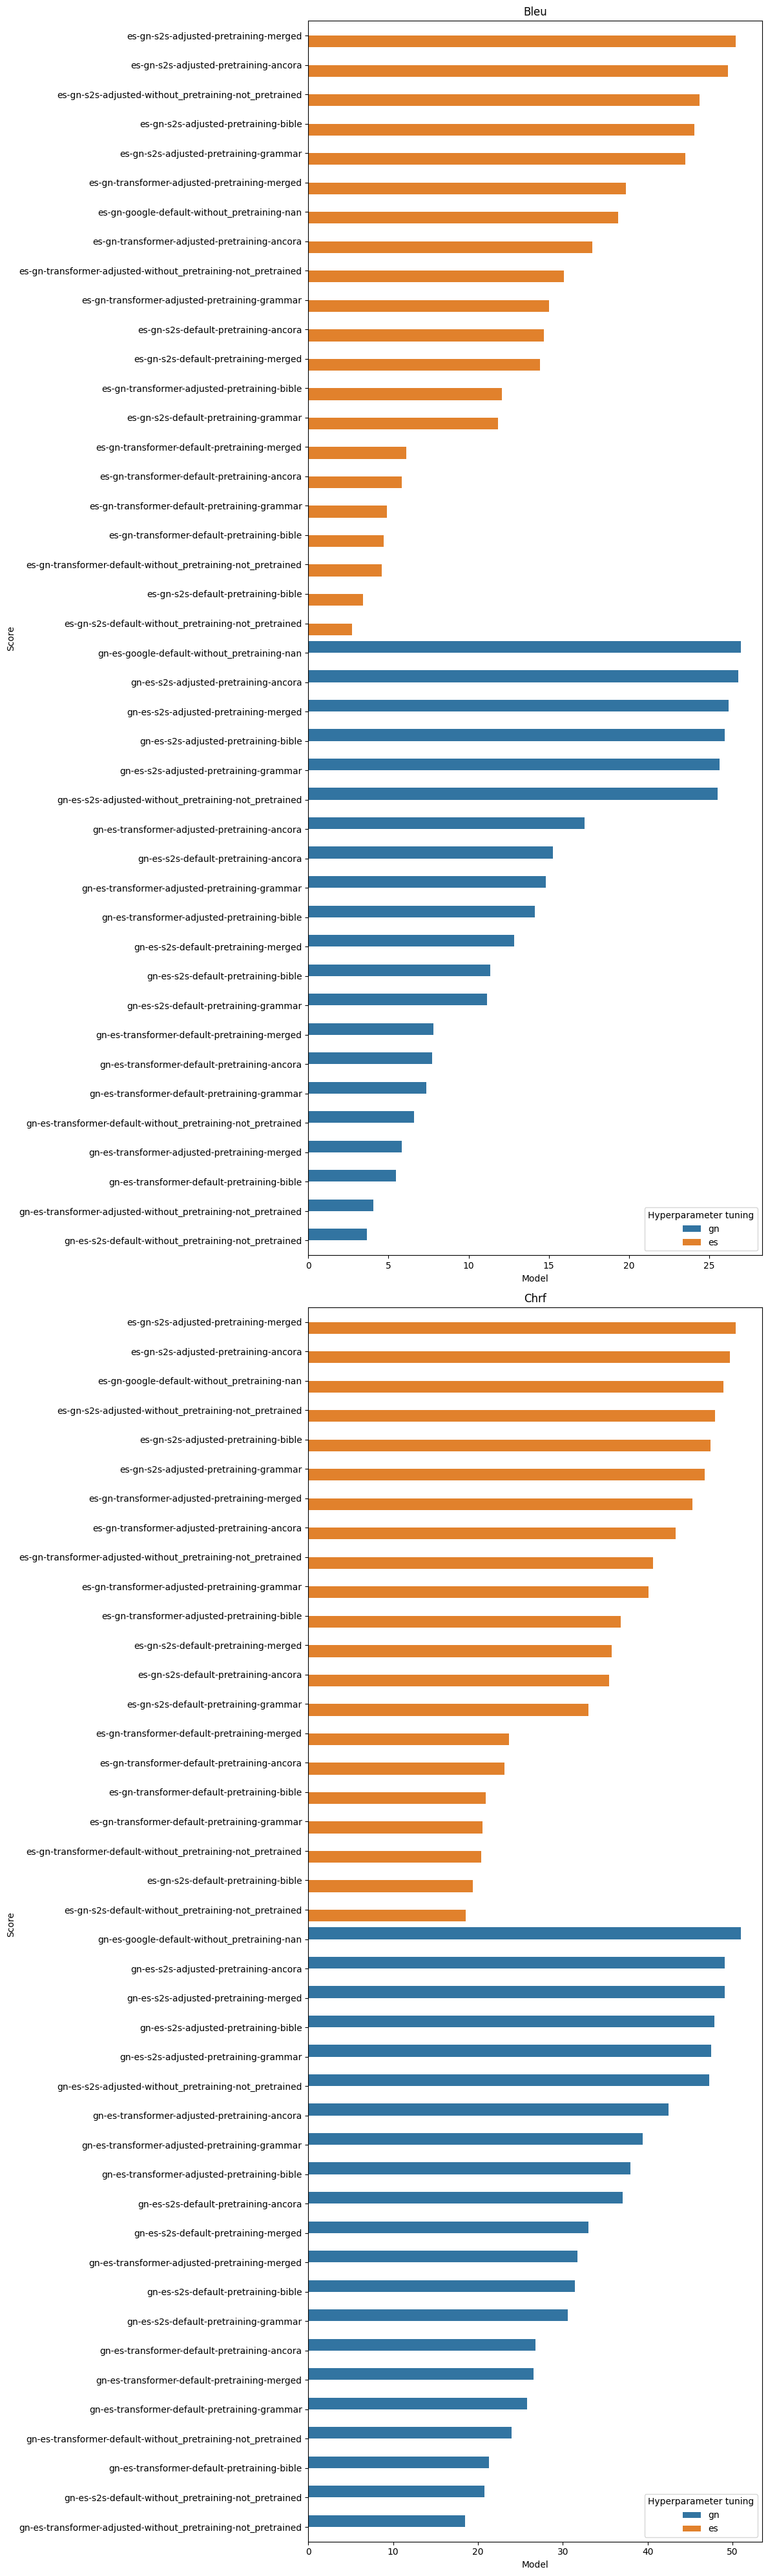

In [146]:
plot_global_scores(df)

### **1.3 Technique Comparison**

The test set involved the following methods:
- Model source: `{ours, google}`
- Model architectures: `{seq2seq, transformers}`
- Pretraining corpus: `{None, grammar, ancora, bible, merged}`
- Hyperparameter tuning: `{adjusted, default}`

In [128]:
def plot_technique_comparison(technique: str):
    fig, ax = plt.subplots(figsize=(15, 6), ncols=2)
    sns.boxplot(x='source', y='sacrebleu_corpus_bleu', 
                    hue=technique,
                    data=df[df['architecture'] != 'google'],
                    ax=ax[0])
    sns.boxplot(x='source', y='sacrebleu_corpus_chrf', 
                    hue=technique,
                    data=df[df['architecture'] != 'google'],
                    ax=ax[1])
    plt.show()

#### **1.3.1. Architecture Comparison**

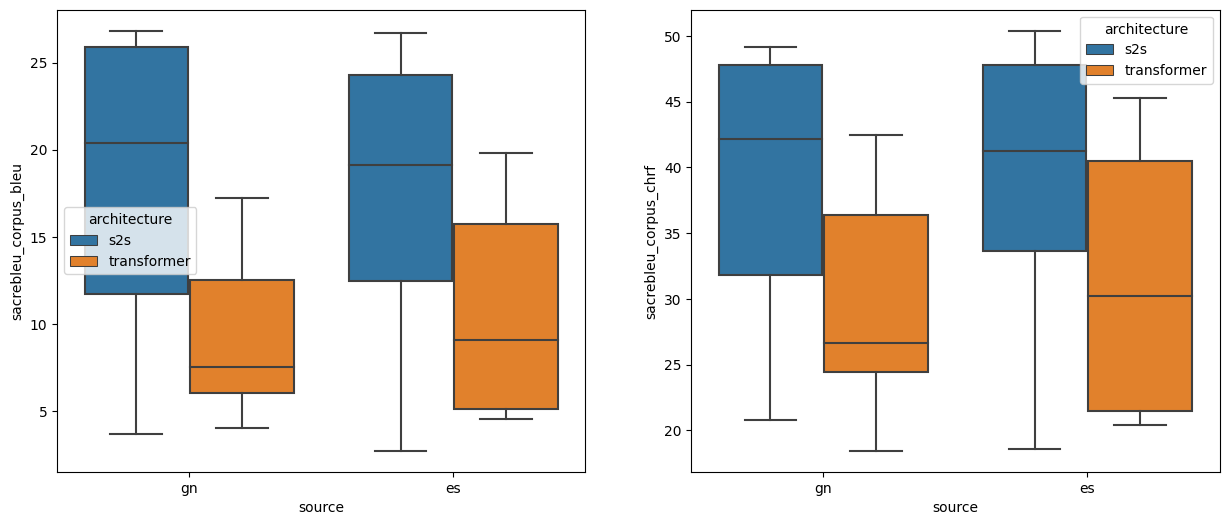

In [147]:
plot_technique_comparison(technique='architecture')

#### **1.3.2. Hyperparameter tuning Comparison**

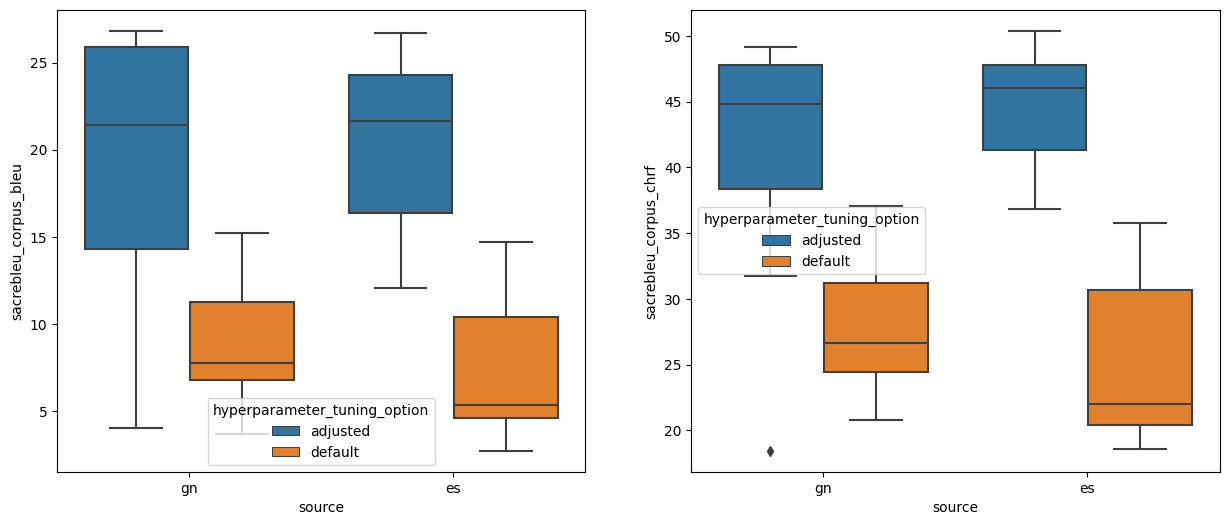

In [130]:
plot_technique_comparison(technique='hyperparameter_tuning_option')

#### **1.3.3. Hyperparameter tuning Comparison**

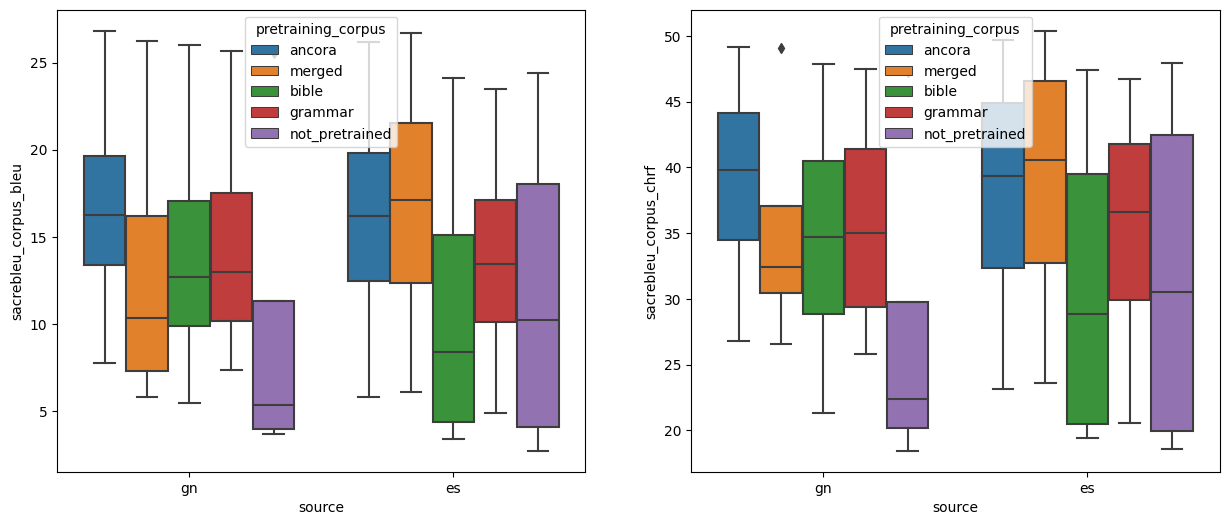

In [131]:
plot_technique_comparison(technique='pretraining_corpus')

## **2. Subset Metrics**

In [212]:
def create_bleu_scores_df(references, translated, bleu_score_types):
    bleu_scores_df = {'reference': [], 
                      'translation': [], 
                      'metric': [], 
                      'score': []}

    for reference, translation in zip(references, translated):
        for bleu_score_type in bleu_score_types:
            bleu_score = metrics.calculate_sacrebleu_sentence(reference, 
                                                translation, 
                                                metric=bleu_score_type)
            bleu_scores_df['reference'].append(reference)
            bleu_scores_df['translation'].append(translation)
            bleu_scores_df['metric'].append(bleu_score_type)
            bleu_scores_df['score'].append(bleu_score)

    return pd.DataFrame(bleu_scores_df)

In [13]:
def get_file_lines(filepath: str, ensure_length=None):
    lines = []
    with open(str(filepath), 'r', encoding='utf-8') as f:
        lines = f.readlines()

    lines = [line[:-1] if line.endswith('\n') else line for line in lines]

    if ensure_length is not None and len(lines) == ensure_length - 1:
        lines = lines + ['']

    return lines

In [14]:
test_gn_filelines = get_file_lines(real_test_set_template.format(trg='gn'))
test_es_filelines = get_file_lines(real_test_set_template.format(trg='es'))
test_length = len(test_gn_filelines)
df['filelines'] = df.apply(lambda row: \
                              get_file_lines(row['filepath'], ensure_length=test_length) if not pd.isna(row['filepath']) else \
                              get_file_lines(GOOGLE_TEST_GN_ES) if row['architecture'] == 'google' and row['source'] == 'gn' else \
                              get_file_lines(GOOGLE_TEST_ES_GN) if row['architecture'] == 'google' and row['source'] == 'es' else \
                              None, 
                           axis=1)

In [15]:
jojajovai_df = pd.read_csv(JOJAJOVAI_DIR)
jojajovai_test_df = jojajovai_df[jojajovai_df['split'] == 'test']
jojajovai_test_df.head()

split source                                                 gn  \
25521  test    abc                                Ko'ágã Cartes turno   
25522  test    abc  Movilización ciudadana oñembyaty ko'ã tendáre ...   
25523  test    abc  Ko'ã manifestante omoî iñakãre ome'ê Yasyretã ...   
25524  test    abc  Tavaygua ko'ã ary oñembyatýva calle España ha ...   
25525  test    abc  Ojehecha despliegue policial ohapejokóva manif...   

                                                      es  \
25521                        Ahora es el turno de Cartes   
25522  La movilización ciudadana se concentra hoy en ...   
25523  Los manifestantes lo responsabilizan de entreg...   
25524  Los ciudadanos de todas las edades se congrega...   
25525  Un importante despliegue policial impidió que ...   

                                               tokens_gn  \
25521                                Ko'ágã Cartes turno   
25522  Movilización ciudadana oñembyaty ko'ã tendáre ...   
25523  Ko'ã manifestante omoî iñakãre ome'ê Yasyretã ...   
25524  Tavaygua ko'ã ary oñembyatýva calle España ha ...   
25525  Ojehecha despliegue policial ohapejokóva manif...   

                                               tokens_es  
25521                        Ahora es el turno de Cartes  
25522  La movilización ciudadana se concentra hoy en ...  
25523  Los manifestantes lo responsabilizan de entreg...  
25524  Los ciudadanos de todas las edades se congrega...  
25525  Un importante despliegue policial impidió que ...

In [133]:
last_source_indices = jojajovai_test_df.groupby(['source']).last()['es'].tolist()
last_source_indices = [test_es_filelines.index(line) for line in last_source_indices]
source_names = jojajovai_test_df['source'].unique().tolist()
source_names

['abc',
 'anlp',
 'blogs',
 'hackaton',
 'libro_gn',
 'libro_td',
 'seminario',
 'spl']

### **2.1 By Corpus Subset**

#### **2.1.1. Subset Length**

One of the main purposes of using pretraining with a grammar was to test whether
using data augmentation for small sentence pairs would enhance translation
quality significantly.

In [134]:
def extract_subset_statistics(source_indices: list[int],
                              last_source_indices: list[int],
                              source_names: list[str],
                              test_gn_filelines: list[str]=test_gn_filelines,
                              test_es_filelines: list[str]=test_es_filelines,
                              plot=True):
    if plot:
        fig, ax = plt.subplots(ncols=len(last_source_indices) // 2, 
                               nrows=2, 
                               figsize=(4*len(last_source_indices), 12))

    current_statistics = collections.defaultdict(list)
    for (start_idx, end_idx), dataset_source in zip(zip(source_indices, 
                                                        last_source_indices),
                                                        source_names):
        subset_gn = test_gn_filelines[start_idx:end_idx+1]
        subset_es = test_es_filelines[start_idx:end_idx+1]
        tokenized_gn = [line.split() for line in subset_gn]
        tokenized_es = [line.split() for line in subset_es]
        tokenized_len_gn = [len(tokens) for tokens in tokenized_gn]
        tokenized_len_es = [len(tokens) for tokens in tokenized_es]

        current_statistics['source'].append(dataset_source)
        current_statistics['source_length'].append(len(subset_gn))
        current_statistics['target_length'].append(len(subset_es))
        current_statistics['source_word_length_median'].append(statistics.median(tokenized_len_gn))
        current_statistics['target_word_length_median'].append(statistics.median(tokenized_len_es))
        current_statistics['source_word_length_mean'].append(statistics.mean(tokenized_len_gn))
        current_statistics['target_word_length_mean'].append(statistics.mean(tokenized_len_es))
        current_statistics['source_word_length_std'].append(statistics.stdev(tokenized_len_gn))
        current_statistics['target_word_length_std'].append(statistics.stdev(tokenized_len_es))

        if plot:
            plot_idx = source_indices.index(start_idx)
            current_ax = ax[plot_idx % 2, plot_idx // 2]
            current_ax.set_title(f'{dataset_source}')
            sns.histplot(tokenized_len_gn, ax=current_ax, color='red', label='source')
            sns.histplot(tokenized_len_es, ax=current_ax, color='blue', label='target')
            current_ax.legend()



    return pd.DataFrame(current_statistics)

In [135]:
def extract_subset_scores(df: pd.DataFrame,
                          source_indices: list[int], 
                          last_source_indices: list[int], 
                          source_names: list[str],
                          score_types: list[str]=score_types,
                          test_gn_filelines: list[str]=test_gn_filelines,
                          test_es_filelines: list[str]=test_es_filelines):
    for metric in score_types:
        for (start_idx, end_idx), dataset_source in zip(zip(source_indices, 
                                                            last_source_indices),
                                                        source_names):
            current_scores = []
            for idx, current_rows in df.iterrows():
                current_filelines = current_rows['filelines']
                test_filelines = test_gn_filelines if current_rows['target'] == 'gn' else test_es_filelines
                current_reference_split = test_filelines[start_idx:end_idx+1]
                current_translation_split = current_filelines[start_idx:end_idx+1]

                if len(current_reference_split) != len(current_translation_split):
                    print(f'WARNING: reference length: {len(current_reference_split)} != current length: {len(current_translation_split)}')
                    current_scores.append(None)
                    continue

                source_score_column = f'{metric}-{dataset_source}'
                current_score = metrics.calculate_metric(current_reference_split, 
                                                        current_translation_split, 
                                                        metric)
                current_scores.append(current_score)
                print(f'{source_score_column}: {current_score}')
            df[source_score_column] = current_scores
    return df

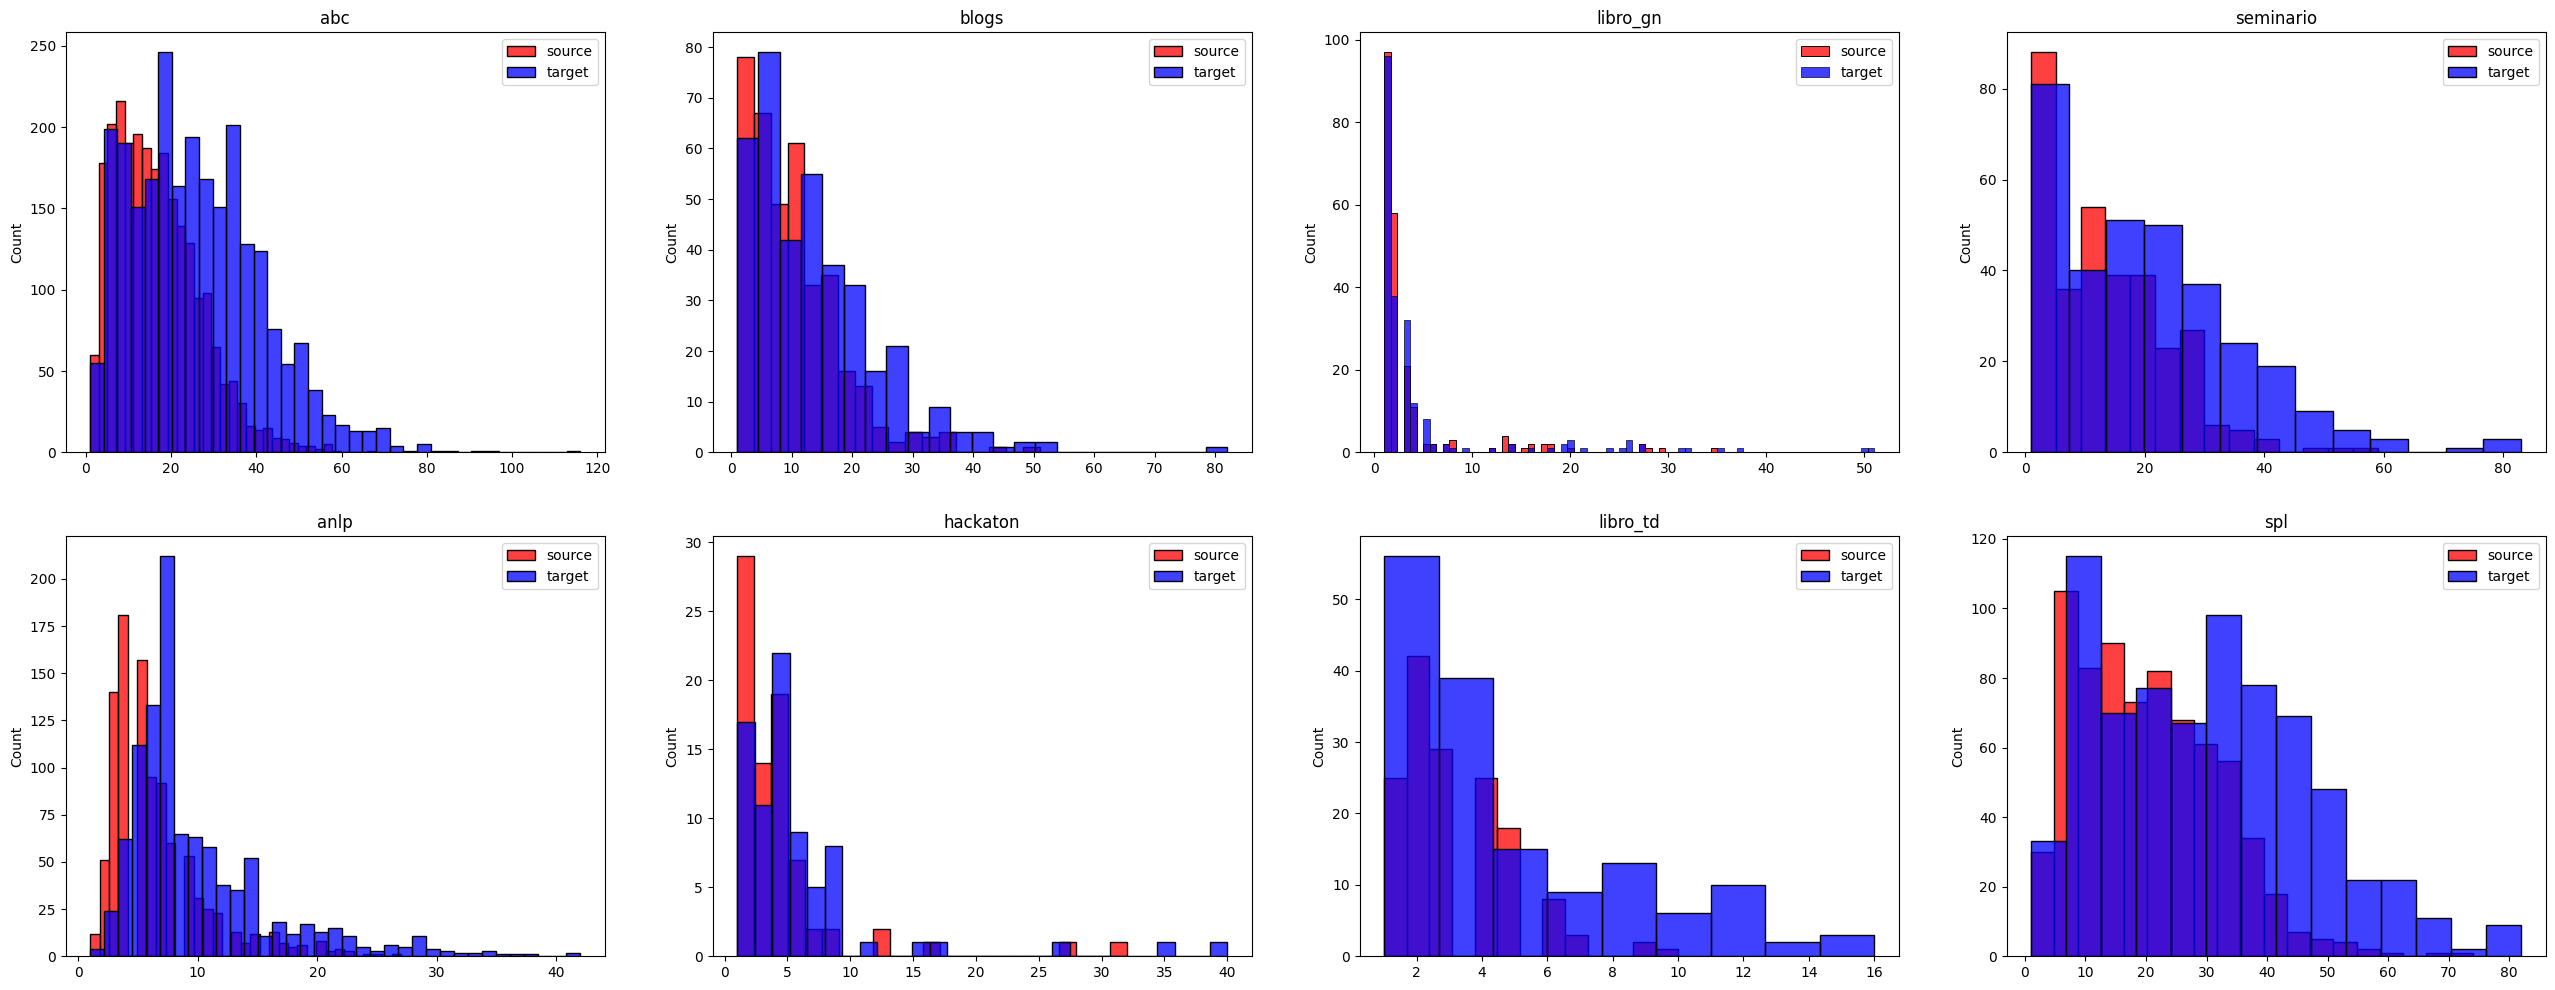

In [136]:
source_indices = [0] + last_source_indices

if not CACHE or not exists_test_set_csv:
    df = extract_subset_scores(df, 
                               source_indices, 
                               last_source_indices, 
                               source_names)

subset_statistics_df = extract_subset_statistics(source_indices, 
                                                 last_source_indices, 
                                                 source_names)

In [137]:
subset_statistics_df.sort_values(by=['target_word_length_median'])

source  source_length  target_length  source_word_length_median  \
4   libro_gn            216            216                        2.0   
5   libro_td            153            153                        3.0   
3   hackaton             78             78                        3.0   
1       anlp           1004           1004                        5.0   
2      blogs            372            372                        9.0   
6  seminario            323            323                       12.0   
0        abc           2470           2470                       16.0   
7        spl            721            721                       20.0   

   target_word_length_median  source_word_length_mean  \
4                        2.0                 3.495370   
5                        3.0                 3.156863   
3                        4.0                 4.487179   
1                        8.0                 6.483068   
2                       12.0                10.190860   
6                       18.0                13.619195   
0                       25.0                17.064372   
7                       29.0                20.438280   

   target_word_length_mean  source_word_length_std  target_word_length_std  
4                 4.671296                5.434599                8.177013  
5                 4.633987                1.770064                3.608746  
3                 5.897436                4.922104                6.427598  
1                10.052789                4.114356                6.270108  
2                13.908602                7.647110               10.558640  
6                20.331269               10.092455               15.692855  
0                26.054656                9.901801               15.212384  
7                29.866852               11.652819               17.067156

**Observation:** The corpus with the lowest word length are:
- libro_gn
- libro_td
- hackaton

#### **2.1.2 Subset Scores**

In [148]:
df = df.sort_index(axis=1).sort_values(by=['source', 'sacrebleu_corpus_bleu'], ascending=False)
df.drop(labels=['filelines'], axis=1).to_csv(TEST_SET_CSV_FILEPATH, index=False)
light_weight_df = df.drop(labels=['filelines', 'filepath'], axis=1)
light_weight_df

architecture hyperparameter_tuning_option  \
0        google                      default   
1           s2s                     adjusted   
2           s2s                     adjusted   
3           s2s                     adjusted   
4           s2s                     adjusted   
5           s2s                     adjusted   
6   transformer                     adjusted   
7           s2s                      default   
8   transformer                     adjusted   
9   transformer                     adjusted   
10          s2s                      default   
11          s2s                      default   
12          s2s                      default   
13  transformer                      default   
14  transformer                      default   
15  transformer                      default   
16  transformer                      default   
17  transformer                     adjusted   
18  transformer                      default   
19  transformer                     adjusted   
20          s2s                      default   
21          s2s                     adjusted   
22          s2s                     adjusted   
23          s2s                     adjusted   
24          s2s                     adjusted   
25          s2s                     adjusted   
26  transformer                     adjusted   
27       google                      default   
28  transformer                     adjusted   
29  transformer                     adjusted   
30  transformer                     adjusted   
31          s2s                      default   
32          s2s                      default   
33  transformer                     adjusted   
34          s2s                      default   
35  transformer                      default   
36  transformer                      default   
37  transformer                      default   
38  transformer                      default   
39  transformer                      default   
40          s2s                      default   
41          s2s                      default   

                                             model_id pretraining_corpus  \
0        gn-es-google-default-without_pretraining-nan                NaN   
1               gn-es-s2s-adjusted-pretraining-ancora             ancora   
2               gn-es-s2s-adjusted-pretraining-merged             merged   
3                gn-es-s2s-adjusted-pretraining-bible              bible   
4              gn-es-s2s-adjusted-pretraining-grammar            grammar   
5   gn-es-s2s-adjusted-without_pretraining-not_pre...     not_pretrained   
6       gn-es-transformer-adjusted-pretraining-ancora             ancora   
7                gn-es-s2s-default-pretraining-ancora             ancora   
8      gn-es-transformer-adjusted-pretraining-grammar            grammar   
9        gn-es-transformer-adjusted-pretraining-bible              bible   
10               gn-es-s2s-default-pretraining-merged             merged   
11                gn-es-s2s-default-pretraining-bible              bible   
12              gn-es-s2s-default-pretraining-grammar            grammar   
13       gn-es-transformer-default-pretraining-merged             merged   
14       gn-es-transformer-default-pretraining-ancora             ancora   
15      gn-es-transformer-default-pretraining-grammar            grammar   
16  gn-es-transformer-default-without_pretraining-...     not_pretrained   
17      gn-es-transformer-adjusted-pretraining-merged             merged   
18        gn-es-transformer-default-pretraining-bible              bible   
19  gn-es-transformer-adjusted-without_pretraining...     not_pretrained   
20  gn-es-s2s-default-without_pretraining-not_pret...     not_pretrained   
21              es-gn-s2s-adjusted-pretraining-merged             merged   
22              es-gn-s2s-adjusted-pretraining-ancora             ancora   
23  es-gn-s2s-adjusted-without_pretraining-not_pre...     not_pretrained   
24               es-gn-s2s-adjusted-pr

In [139]:
identifier_columns = ['source', 'target', 'architecture', 'hyperparameter_tuning_option', 'pretraining_corpus', 'pretraining_option']

In [140]:
def extract_metric_from_subset(df: pd.DataFrame,
                               subset: str, 
                               metrics: list[str], 
                               identifier_columns=identifier_columns, 
                               sort=True):
    metric_columns = [f'{metric}-{subset}' for metric in metrics]
    metric_columns = [[metrics[i], metric_columns[i]] for i in range(len(metrics))]
    metric_columns = sum(metric_columns, [])
    current_df = df[identifier_columns + metric_columns]

    if sort:
        current_df = current_df.sort_values(['source', metric_columns[1]], ascending=False)
        
    return current_df

In [193]:
def create_pretraining_pairs_df(pair_rows: list[pd.Series], subset: str):
    pair_data = []
    for grammar_row, no_pretraining_row in pair_rows:
        for metric in ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf']:
            metric = metric + '-' + subset
            grammar_score = grammar_row[metric]
            no_pretraining_score = no_pretraining_row[metric]
            improvement = grammar_score - no_pretraining_score
            pair_data.append({
                'source': grammar_row['source'],
                'target': grammar_row['target'],
                'architecture': grammar_row['architecture'],
                'hyperparameter_tuning_option': grammar_row['hyperparameter_tuning_option'],
                'metric': metric,
                'improvement': improvement
            })
    return pair_data
        

def match_pretraining_enhancement(pretraining_corpus: str, subset: str):
    grammar_df = light_weight_df[(light_weight_df['pretraining_corpus']==pretraining_corpus) | 
                                (light_weight_df['pretraining_option']=='without_pretraining')]
    grammar_df['model_id'] = grammar_df['model_id'].cat.remove_unused_categories()

    pair_rows = []
    for _, grammar_row in grammar_df.iterrows():
        if grammar_row['pretraining_corpus'] != pretraining_corpus:
            continue

        for _, no_pretraining_row in grammar_df.iterrows():
            if no_pretraining_row['pretraining_corpus'] != 'not_pretrained':
                continue

            if grammar_row['source'] != no_pretraining_row['source']:
                continue

            if grammar_row['architecture'] != no_pretraining_row['architecture']:
                continue

            if grammar_row['hyperparameter_tuning_option'] != no_pretraining_row['hyperparameter_tuning_option']:
                continue

            pair_rows.append((grammar_row, no_pretraining_row))

    pair_data = create_pretraining_pairs_df(pair_rows, subset)
    pair_df = pd.DataFrame(pair_data)
    pair_df['model_id'] = pair_df['source'] + '-' + pair_df['target'] + '-' + pair_df['architecture'] + '-' + pair_df['hyperparameter_tuning_option']

    return pair_df

##### **2.1.2.1. ABC**

In [80]:
current_df = extract_metric_from_subset(light_weight_df, 'abc', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
1      gn     es          s2s                     adjusted             ancora   
0      gn     es       google                      default                NaN   
2      gn     es          s2s                     adjusted             merged   
4      gn     es          s2s                     adjusted            grammar   
3      gn     es          s2s                     adjusted              bible   
5      gn     es          s2s                     adjusted     not_pretrained   
6      gn     es  transformer                     adjusted             ancora   
7      gn     es          s2s                      default             ancora   
8      gn     es  transformer                     adjusted            grammar   
9      gn     es  transformer                     adjusted              bible   
10     gn     es          s2s                      default             merged   
11     gn     es          s2s                      default              bible   
12     gn     es          s2s                      default            grammar   
13     gn     es  transformer                      default             merged   
14     gn     es  transformer                      default             ancora   
15     gn     es  transformer                      default            grammar   
16     gn     es  transformer                      default     not_pretrained   
18     gn     es  transformer                      default              bible   
19     gn     es  transformer                     adjusted     not_pretrained   
20     gn     es          s2s                      default     not_pretrained   
17     gn     es  transformer                     adjusted             merged   
21     es     gn          s2s                     adjusted             merged   
22     es     gn          s2s                     adjusted             ancora   
23     es     gn          s2s                     adjusted     not_pretrained   
24     es     gn          s2s                     adjusted              bible   
25     es     gn          s2s                     adjusted            grammar   
27     es     gn       google                      default                NaN   
26     es     gn  transformer                     adjusted             merged   
28     es     gn  transformer                     adjusted             ancora   
31     es     gn          s2s                      default             ancora   
29     es     gn  transformer                     adjusted     not_pretrained   
30     es     gn  transformer                     adjusted            grammar   
32     es     gn          s2s                      default             merged   
34     es     gn          s2s                      default            grammar   
33     es     gn  transformer                     adjusted              bible   
35     es     gn  transformer                      default             merged   
36     es     gn  transformer                      default             ancora   
37     es     gn  transformer                      default            grammar   
39     es     gn  transformer                      default     not_pretrained   
38     es     gn  transformer                      default              bible   
40     es     gn          s2s                      default              bible   
41     es     gn          s2s                      default     not_pretrained   

     pretraining_option  sacrebleu_corpus_bleu  sacrebleu_corpus_bleu-abc  \
1           pretraining               26.82430                  30.812751   
0   without_pretraining               26.96310                  30.807921   
2           pretraining               26.20750                  30.050224   
4           pretraining               25.65810                  29.133680   
3           pretraining               25.99190                  28.763915   
5   without_pretraining               25.53840           

##### **2.1.2.2. ANLP**

In [81]:
current_df = extract_metric_from_subset(light_weight_df, 'anlp', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
2      gn     es          s2s                     adjusted             merged   
1      gn     es          s2s                     adjusted             ancora   
4      gn     es          s2s                     adjusted            grammar   
3      gn     es          s2s                     adjusted              bible   
5      gn     es          s2s                     adjusted     not_pretrained   
7      gn     es          s2s                      default             ancora   
6      gn     es  transformer                     adjusted             ancora   
8      gn     es  transformer                     adjusted            grammar   
9      gn     es  transformer                     adjusted              bible   
10     gn     es          s2s                      default             merged   
13     gn     es  transformer                      default             merged   
12     gn     es          s2s                      default            grammar   
15     gn     es  transformer                      default            grammar   
11     gn     es          s2s                      default              bible   
14     gn     es  transformer                      default             ancora   
18     gn     es  transformer                      default              bible   
16     gn     es  transformer                      default     not_pretrained   
20     gn     es          s2s                      default     not_pretrained   
19     gn     es  transformer                     adjusted     not_pretrained   
17     gn     es  transformer                     adjusted             merged   
27     es     gn       google                      default                NaN   
21     es     gn          s2s                     adjusted             merged   
22     es     gn          s2s                     adjusted             ancora   
24     es     gn          s2s                     adjusted              bible   
26     es     gn  transformer                     adjusted             merged   
25     es     gn          s2s                     adjusted            grammar   
23     es     gn          s2s                     adjusted     not_pretrained   
28     es     gn  transformer                     adjusted             ancora   
30     es     gn  transformer                     adjusted            grammar   
32     es     gn          s2s                      default             merged   
31     es     gn          s2s                      default             ancora   
29     es     gn  transformer                     adjusted     not_pretrained   
33     es     gn  transformer                     adjusted              bible   
35     es     gn  transformer                      default             merged   
34     es     gn          s2s                      default            grammar   
37     es     gn  transformer                      default            grammar   
36     es     gn  transformer                      default             ancora   
38     es     gn  transformer                      default              bible   
39     es     gn  transformer                      default     not_pretrained   
40     es     gn          s2s                      default              bible   
41     es     gn          s2s                      default     not_pretrained   

     pretraining_option  sacrebleu_corpus_bleu  sacrebleu_corpus_bleu-anlp  \
0   without_pretraining               26.96310                   19.803664   
2           pretraining               26.20750                    4.325097   
1           pretraining               26.82430                    4.036580   
4           pretraining               25.65810                    3.060952   
3           pretraining               25.99190                    2.996033   
5   without_pretraining               25.53840     

##### **2.1.2.3. blogs**

In [82]:
current_df = extract_metric_from_subset(light_weight_df, 'blogs', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
2      gn     es          s2s                     adjusted             merged   
1      gn     es          s2s                     adjusted             ancora   
3      gn     es          s2s                     adjusted              bible   
5      gn     es          s2s                     adjusted     not_pretrained   
4      gn     es          s2s                     adjusted            grammar   
6      gn     es  transformer                     adjusted             ancora   
8      gn     es  transformer                     adjusted            grammar   
7      gn     es          s2s                      default             ancora   
9      gn     es  transformer                     adjusted              bible   
10     gn     es          s2s                      default             merged   
12     gn     es          s2s                      default            grammar   
11     gn     es          s2s                      default              bible   
15     gn     es  transformer                      default            grammar   
14     gn     es  transformer                      default             ancora   
13     gn     es  transformer                      default             merged   
16     gn     es  transformer                      default     not_pretrained   
18     gn     es  transformer                      default              bible   
20     gn     es          s2s                      default     not_pretrained   
19     gn     es  transformer                     adjusted     not_pretrained   
17     gn     es  transformer                     adjusted             merged   
27     es     gn       google                      default                NaN   
21     es     gn          s2s                     adjusted             merged   
22     es     gn          s2s                     adjusted             ancora   
25     es     gn          s2s                     adjusted            grammar   
24     es     gn          s2s                     adjusted              bible   
23     es     gn          s2s                     adjusted     not_pretrained   
26     es     gn  transformer                     adjusted             merged   
28     es     gn  transformer                     adjusted             ancora   
30     es     gn  transformer                     adjusted            grammar   
29     es     gn  transformer                     adjusted     not_pretrained   
31     es     gn          s2s                      default             ancora   
32     es     gn          s2s                      default             merged   
33     es     gn  transformer                     adjusted              bible   
34     es     gn          s2s                      default            grammar   
35     es     gn  transformer                      default             merged   
36     es     gn  transformer                      default             ancora   
39     es     gn  transformer                      default     not_pretrained   
38     es     gn  transformer                      default              bible   
37     es     gn  transformer                      default            grammar   
40     es     gn          s2s                      default              bible   
41     es     gn          s2s                      default     not_pretrained   

     pretraining_option  sacrebleu_corpus_bleu  sacrebleu_corpus_bleu-blogs  \
0   without_pretraining               26.96310                    24.445486   
2           pretraining               26.20750                    18.442991   
1           pretraining               26.82430                    18.128379   
3           pretraining               25.99190                    17.220267   
5   without_pretraining               25.53840                    16.094188   
4           pretraining               25.6581

##### **2.1.2.4. Hackaton (Short sentence pairs)**

In [202]:
current_df = extract_metric_from_subset(light_weight_df, 'hackaton', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
2      gn     es          s2s                     adjusted             merged   
5      gn     es          s2s                     adjusted     not_pretrained   
4      gn     es          s2s                     adjusted            grammar   
1      gn     es          s2s                     adjusted             ancora   
3      gn     es          s2s                     adjusted              bible   
10     gn     es          s2s                      default             merged   
8      gn     es  transformer                     adjusted            grammar   
6      gn     es  transformer                     adjusted             ancora   
7      gn     es          s2s                      default             ancora   
14     gn     es  transformer                      default             ancora   
15     gn     es  transformer                      default            grammar   
16     gn     es  transformer                      default     not_pretrained   
13     gn     es  transformer                      default             merged   
9      gn     es  transformer                     adjusted              bible   
12     gn     es          s2s                      default            grammar   
11     gn     es          s2s                      default              bible   
18     gn     es  transformer                      default              bible   
20     gn     es          s2s                      default     not_pretrained   
19     gn     es  transformer                     adjusted     not_pretrained   
17     gn     es  transformer                     adjusted             merged   
27     es     gn       google                      default                NaN   
21     es     gn          s2s                     adjusted             merged   
23     es     gn          s2s                     adjusted     not_pretrained   
22     es     gn          s2s                     adjusted             ancora   
25     es     gn          s2s                     adjusted            grammar   
34     es     gn          s2s                      default            grammar   
37     es     gn  transformer                      default            grammar   
33     es     gn  transformer                     adjusted              bible   
26     es     gn  transformer                     adjusted             merged   
38     es     gn  transformer                      default              bible   
29     es     gn  transformer                     adjusted     not_pretrained   
30     es     gn  transformer                     adjusted            grammar   
35     es     gn  transformer                      default             merged   
28     es     gn  transformer                     adjusted             ancora   
24     es     gn          s2s                     adjusted              bible   
32     es     gn          s2s                      default             merged   
31     es     gn          s2s                      default             ancora   
41     es     gn          s2s                      default     not_pretrained   
36     es     gn  transformer                      default             ancora   
39     es     gn  transformer                      default     not_pretrained   
40     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  \
0   without_pretraining               26.96310   
2           pretraining               26.20750   
5   without_pretraining               25.53840   
4           pretraining               25.65810   
1           pretraining               26.82430   
3           pretraining               25.99190   
10          pretraining               12.84710   
8           pretraining               14.79290   
6           pretraining               17.23800   
7           pretrai

In [203]:
pair_df = match_pretraining_enhancement(pretraining_corpus='grammar', subset='hackaton')
pair_df


source target architecture hyperparameter_tuning_option  \
0      gn     es          s2s                     adjusted   
1      gn     es          s2s                     adjusted   
2      gn     es  transformer                     adjusted   
3      gn     es  transformer                     adjusted   
4      gn     es          s2s                      default   
5      gn     es          s2s                      default   
6      gn     es  transformer                      default   
7      gn     es  transformer                      default   
8      es     gn          s2s                     adjusted   
9      es     gn          s2s                     adjusted   
10     es     gn  transformer                     adjusted   
11     es     gn  transformer                     adjusted   
12     es     gn          s2s                      default   
13     es     gn          s2s                      default   
14     es     gn  transformer                      default   
15     es     gn  transformer                      default   

                            metric  improvement                    model_id  
0   sacrebleu_corpus_bleu-hackaton    -1.205497          gn-es-s2s-adjusted  
1   sacrebleu_corpus_chrf-hackaton     0.231848          gn-es-s2s-adjusted  
2   sacrebleu_corpus_bleu-hackaton     6.328313  gn-es-transformer-adjusted  
3   sacrebleu_corpus_chrf-hackaton    13.670621  gn-es-transformer-adjusted  
4   sacrebleu_corpus_bleu-hackaton     1.826391           gn-es-s2s-default  
5   sacrebleu_corpus_chrf-hackaton     1.242237           gn-es-s2s-default  
6   sacrebleu_corpus_bleu-hackaton     0.013076   gn-es-transformer-default  
7   sacrebleu_corpus_chrf-hackaton     2.137138   gn-es-transformer-default  
8   sacrebleu_corpus_bleu-hackaton    -0.262846          es-gn-s2s-adjusted  
9   sacrebleu_corpus_chrf-hackaton     1.545776          es-gn-s2s-adjusted  
10  sacrebleu_corpus_bleu-hackaton    -0.073274  es-gn-transformer-adjusted  
11  sacrebleu_corpus_chrf-hackaton     2.174289  es-gn-transformer-adjusted  
12  sacrebleu_corpus_bleu-hackaton     1.557054           es-gn-s2s-default  
13  sacrebleu_corpus_chrf-hackaton     8.248393           es-gn-s2s-default  
14  sacrebleu_corpus_bleu-hackaton     1.612057   es-gn-transformer-default  
15  sacrebleu_corpus_chrf-hackaton     3.284423   es-gn-transformer-default

In [205]:
pair_df.describe()

improvement
count    16.000000
mean      2.645625
std       3.802942
min      -1.205497
25%       0.177155
50%       1.584555
75%       2.451822
max      13.670621

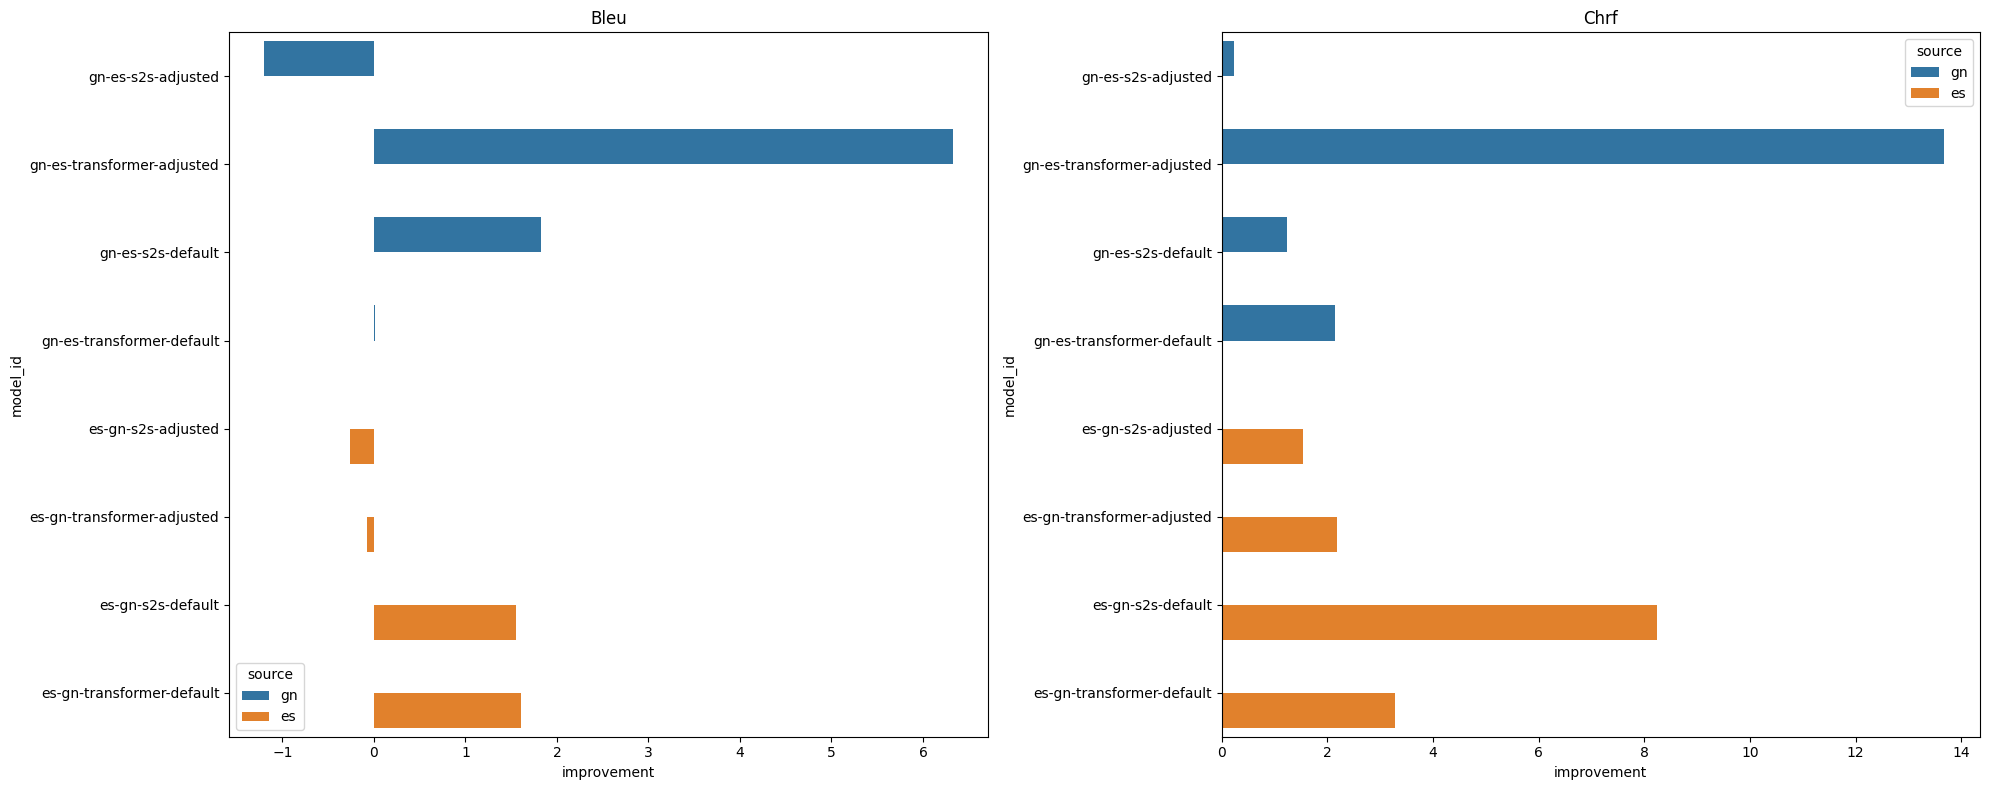

In [204]:
fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_bleu-hackaton'], ax=ax[0]);
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_chrf-hackaton'], ax=ax[1]);

ax[0].set_title('Bleu')
ax[1].set_title('Chrf')
plt.tight_layout()

##### **2.1.2.5. libro_gn**

In [196]:
current_df = extract_metric_from_subset(light_weight_df, 'libro_gn', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
3      gn     es          s2s                     adjusted              bible   
1      gn     es          s2s                     adjusted             ancora   
5      gn     es          s2s                     adjusted     not_pretrained   
2      gn     es          s2s                     adjusted             merged   
4      gn     es          s2s                     adjusted            grammar   
7      gn     es          s2s                      default             ancora   
8      gn     es  transformer                     adjusted            grammar   
6      gn     es  transformer                     adjusted             ancora   
9      gn     es  transformer                     adjusted              bible   
12     gn     es          s2s                      default            grammar   
10     gn     es          s2s                      default             merged   
13     gn     es  transformer                      default             merged   
16     gn     es  transformer                      default     not_pretrained   
15     gn     es  transformer                      default            grammar   
14     gn     es  transformer                      default             ancora   
11     gn     es          s2s                      default              bible   
18     gn     es  transformer                      default              bible   
20     gn     es          s2s                      default     not_pretrained   
19     gn     es  transformer                     adjusted     not_pretrained   
17     gn     es  transformer                     adjusted             merged   
22     es     gn          s2s                     adjusted             ancora   
23     es     gn          s2s                     adjusted     not_pretrained   
27     es     gn       google                      default                NaN   
21     es     gn          s2s                     adjusted             merged   
24     es     gn          s2s                     adjusted              bible   
25     es     gn          s2s                     adjusted            grammar   
26     es     gn  transformer                     adjusted             merged   
32     es     gn          s2s                      default             merged   
31     es     gn          s2s                      default             ancora   
34     es     gn          s2s                      default            grammar   
29     es     gn  transformer                     adjusted     not_pretrained   
28     es     gn  transformer                     adjusted             ancora   
30     es     gn  transformer                     adjusted            grammar   
37     es     gn  transformer                      default            grammar   
39     es     gn  transformer                      default     not_pretrained   
33     es     gn  transformer                     adjusted              bible   
35     es     gn  transformer                      default             merged   
36     es     gn  transformer                      default             ancora   
38     es     gn  transformer                      default              bible   
41     es     gn          s2s                      default     not_pretrained   
40     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  \
0   without_pretraining               26.96310   
3           pretraining               25.99190   
1           pretraining               26.82430   
5   without_pretraining               25.53840   
2           pretraining               26.20750   
4           pretraining               25.65810   
7           pretraining               15.24250   
8           pretraining               14.79290   
6           pretraining               17.23800   
9           pretrai

In [198]:
pair_df = match_pretraining_enhancement(pretraining_corpus='grammar', subset='libro_gn')
pair_df

source target architecture hyperparameter_tuning_option  \
0      gn     es          s2s                     adjusted   
1      gn     es          s2s                     adjusted   
2      gn     es  transformer                     adjusted   
3      gn     es  transformer                     adjusted   
4      gn     es          s2s                      default   
5      gn     es          s2s                      default   
6      gn     es  transformer                      default   
7      gn     es  transformer                      default   
8      es     gn          s2s                     adjusted   
9      es     gn          s2s                     adjusted   
10     es     gn  transformer                     adjusted   
11     es     gn  transformer                     adjusted   
12     es     gn          s2s                      default   
13     es     gn          s2s                      default   
14     es     gn  transformer                      default   
15     es     gn  transformer                      default   

                            metric  improvement                    model_id  
0   sacrebleu_corpus_bleu-libro_gn    -0.780398          gn-es-s2s-adjusted  
1   sacrebleu_corpus_chrf-libro_gn    -3.083494          gn-es-s2s-adjusted  
2   sacrebleu_corpus_bleu-libro_gn     5.548859  gn-es-transformer-adjusted  
3   sacrebleu_corpus_chrf-libro_gn    14.541545  gn-es-transformer-adjusted  
4   sacrebleu_corpus_bleu-libro_gn     3.759988           gn-es-s2s-default  
5   sacrebleu_corpus_chrf-libro_gn     1.434914           gn-es-s2s-default  
6   sacrebleu_corpus_bleu-libro_gn    -0.007133   gn-es-transformer-default  
7   sacrebleu_corpus_chrf-libro_gn    -0.542085   gn-es-transformer-default  
8   sacrebleu_corpus_bleu-libro_gn    -1.670821          es-gn-s2s-adjusted  
9   sacrebleu_corpus_chrf-libro_gn    -2.380558          es-gn-s2s-adjusted  
10  sacrebleu_corpus_bleu-libro_gn    -1.553455  es-gn-transformer-adjusted  
11  sacrebleu_corpus_chrf-libro_gn    -3.704620  es-gn-transformer-adjusted  
12  sacrebleu_corpus_bleu-libro_gn     3.611138           es-gn-s2s-default  
13  sacrebleu_corpus_chrf-libro_gn     2.871496           es-gn-s2s-default  
14  sacrebleu_corpus_bleu-libro_gn     0.379168   es-gn-transformer-default  
15  sacrebleu_corpus_chrf-libro_gn     1.090051   es-gn-transformer-default

In [ ]:
pair_df.describe()

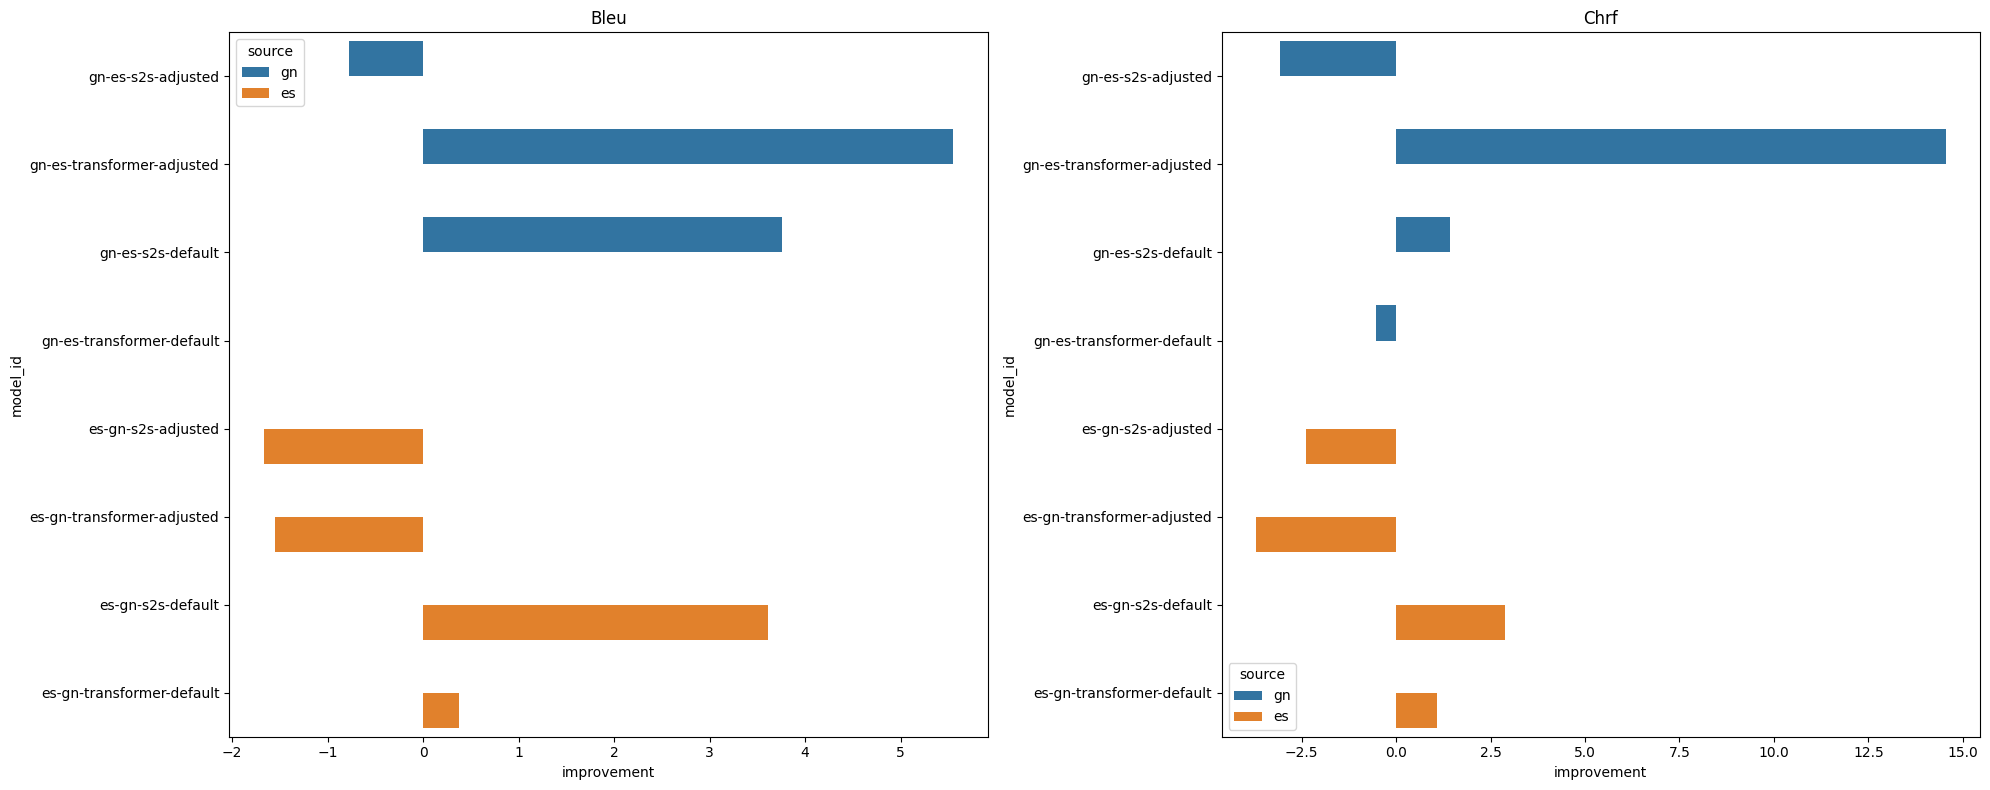

In [199]:
fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_bleu-libro_gn'], ax=ax[0]);
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_chrf-libro_gn'], ax=ax[1]);

ax[0].set_title('Bleu')
ax[1].set_title('Chrf')
plt.tight_layout()

##### **2.1.2.6. libro_td**

In [85]:
current_df = extract_metric_from_subset(light_weight_df, 'libro_td', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
1      gn     es          s2s                     adjusted             ancora   
5      gn     es          s2s                     adjusted     not_pretrained   
3      gn     es          s2s                     adjusted              bible   
2      gn     es          s2s                     adjusted             merged   
8      gn     es  transformer                     adjusted            grammar   
4      gn     es          s2s                     adjusted            grammar   
13     gn     es  transformer                      default             merged   
6      gn     es  transformer                     adjusted             ancora   
7      gn     es          s2s                      default             ancora   
18     gn     es  transformer                      default              bible   
10     gn     es          s2s                      default             merged   
9      gn     es  transformer                     adjusted              bible   
15     gn     es  transformer                      default            grammar   
14     gn     es  transformer                      default             ancora   
0      gn     es       google                      default                NaN   
11     gn     es          s2s                      default              bible   
16     gn     es  transformer                      default     not_pretrained   
12     gn     es          s2s                      default            grammar   
20     gn     es          s2s                      default     not_pretrained   
19     gn     es  transformer                     adjusted     not_pretrained   
17     gn     es  transformer                     adjusted             merged   
21     es     gn          s2s                     adjusted             merged   
29     es     gn  transformer                     adjusted     not_pretrained   
25     es     gn          s2s                     adjusted            grammar   
22     es     gn          s2s                     adjusted             ancora   
32     es     gn          s2s                      default             merged   
26     es     gn  transformer                     adjusted             merged   
24     es     gn          s2s                     adjusted              bible   
23     es     gn          s2s                     adjusted     not_pretrained   
38     es     gn  transformer                      default              bible   
34     es     gn          s2s                      default            grammar   
35     es     gn  transformer                      default             merged   
36     es     gn  transformer                      default             ancora   
30     es     gn  transformer                     adjusted            grammar   
39     es     gn  transformer                      default     not_pretrained   
28     es     gn  transformer                     adjusted             ancora   
31     es     gn          s2s                      default             ancora   
37     es     gn  transformer                      default            grammar   
33     es     gn  transformer                     adjusted              bible   
27     es     gn       google                      default                NaN   
41     es     gn          s2s                      default     not_pretrained   
40     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  \
1           pretraining               26.82430   
5   without_pretraining               25.53840   
3           pretraining               25.99190   
2           pretraining               26.20750   
8           pretraining               14.79290   
4           pretraining               25.65810   
13          pretraining                7.79707   
6           pretraining               17.23800   
7           pretraining               15.24250   
18          pretrai

In [200]:
pair_df = match_pretraining_enhancement(pretraining_corpus='grammar', subset='libro_td')
pair_df

source target architecture hyperparameter_tuning_option  \
0      gn     es          s2s                     adjusted   
1      gn     es          s2s                     adjusted   
2      gn     es  transformer                     adjusted   
3      gn     es  transformer                     adjusted   
4      gn     es          s2s                      default   
5      gn     es          s2s                      default   
6      gn     es  transformer                      default   
7      gn     es  transformer                      default   
8      es     gn          s2s                     adjusted   
9      es     gn          s2s                     adjusted   
10     es     gn  transformer                     adjusted   
11     es     gn  transformer                     adjusted   
12     es     gn          s2s                      default   
13     es     gn          s2s                      default   
14     es     gn  transformer                      default   
15     es     gn  transformer                      default   

                            metric  improvement                    model_id  
0   sacrebleu_corpus_bleu-libro_td    -3.764071          gn-es-s2s-adjusted  
1   sacrebleu_corpus_chrf-libro_td    -1.750997          gn-es-s2s-adjusted  
2   sacrebleu_corpus_bleu-libro_td    12.780990  gn-es-transformer-adjusted  
3   sacrebleu_corpus_chrf-libro_td    23.417763  gn-es-transformer-adjusted  
4   sacrebleu_corpus_bleu-libro_td     0.548601           gn-es-s2s-default  
5   sacrebleu_corpus_chrf-libro_td     0.983322           gn-es-s2s-default  
6   sacrebleu_corpus_bleu-libro_td     1.043552   gn-es-transformer-default  
7   sacrebleu_corpus_chrf-libro_td     0.979662   gn-es-transformer-default  
8   sacrebleu_corpus_bleu-libro_td     1.669106          es-gn-s2s-adjusted  
9   sacrebleu_corpus_chrf-libro_td     1.614308          es-gn-s2s-adjusted  
10  sacrebleu_corpus_bleu-libro_td    -3.095724  es-gn-transformer-adjusted  
11  sacrebleu_corpus_chrf-libro_td    -0.838313  es-gn-transformer-adjusted  
12  sacrebleu_corpus_bleu-libro_td     4.042426           es-gn-s2s-default  
13  sacrebleu_corpus_chrf-libro_td     9.260539           es-gn-s2s-default  
14  sacrebleu_corpus_bleu-libro_td    -0.889915   es-gn-transformer-default  
15  sacrebleu_corpus_chrf-libro_td     2.876087   es-gn-transformer-default

In [ ]:
pair_df.describe()

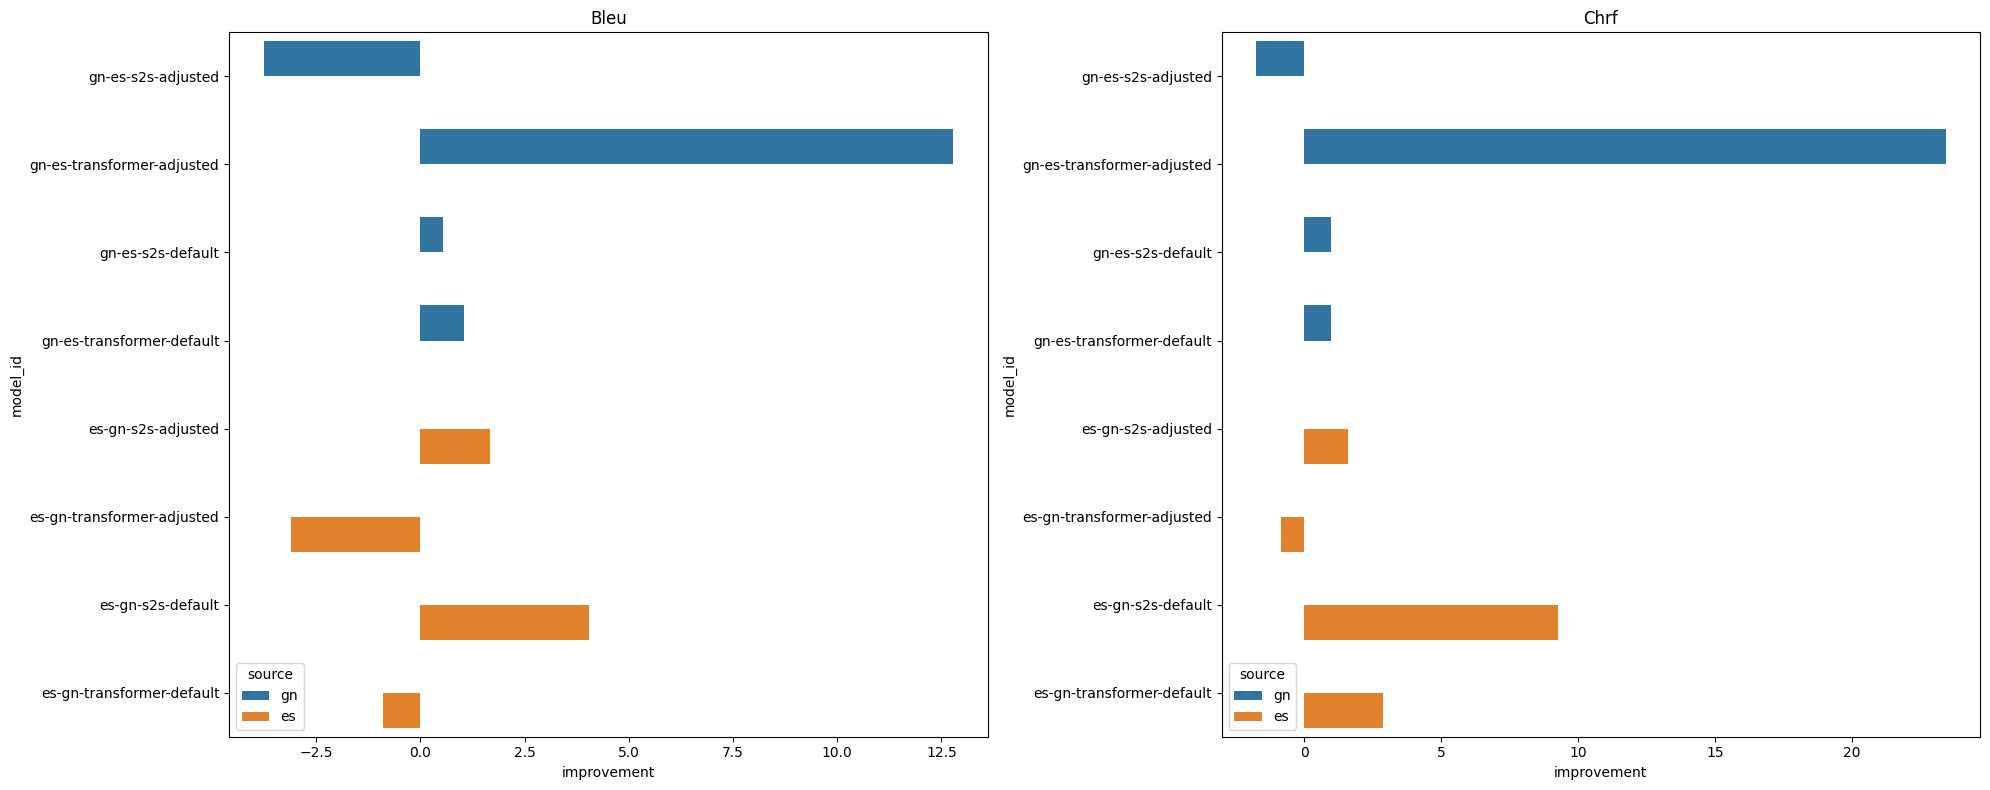

In [201]:
fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_bleu-libro_td'], ax=ax[0]);
sns.barplot(y='model_id', x='improvement', hue='source', data=pair_df[pair_df['metric']=='sacrebleu_corpus_chrf-libro_td'], ax=ax[1]);

ax[0].set_title('Bleu')
ax[1].set_title('Chrf')
plt.tight_layout()

##### **2.1.2.7. seminario**

In [86]:
current_df = extract_metric_from_subset(light_weight_df, 'seminario', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
0      gn     es       google                      default                NaN   
1      gn     es          s2s                     adjusted             ancora   
2      gn     es          s2s                     adjusted             merged   
5      gn     es          s2s                     adjusted     not_pretrained   
3      gn     es          s2s                     adjusted              bible   
4      gn     es          s2s                     adjusted            grammar   
6      gn     es  transformer                     adjusted             ancora   
8      gn     es  transformer                     adjusted            grammar   
9      gn     es  transformer                     adjusted              bible   
7      gn     es          s2s                      default             ancora   
10     gn     es          s2s                      default             merged   
11     gn     es          s2s                      default              bible   
12     gn     es          s2s                      default            grammar   
13     gn     es  transformer                      default             merged   
15     gn     es  transformer                      default            grammar   
14     gn     es  transformer                      default             ancora   
16     gn     es  transformer                      default     not_pretrained   
19     gn     es  transformer                     adjusted     not_pretrained   
20     gn     es          s2s                      default     not_pretrained   
18     gn     es  transformer                      default              bible   
17     gn     es  transformer                     adjusted             merged   
27     es     gn       google                      default                NaN   
22     es     gn          s2s                     adjusted             ancora   
21     es     gn          s2s                     adjusted             merged   
24     es     gn          s2s                     adjusted              bible   
23     es     gn          s2s                     adjusted     not_pretrained   
25     es     gn          s2s                     adjusted            grammar   
26     es     gn  transformer                     adjusted             merged   
28     es     gn  transformer                     adjusted             ancora   
30     es     gn  transformer                     adjusted            grammar   
29     es     gn  transformer                     adjusted     not_pretrained   
33     es     gn  transformer                     adjusted              bible   
32     es     gn          s2s                      default             merged   
31     es     gn          s2s                      default             ancora   
34     es     gn          s2s                      default            grammar   
35     es     gn  transformer                      default             merged   
37     es     gn  transformer                      default            grammar   
38     es     gn  transformer                      default              bible   
39     es     gn  transformer                      default     not_pretrained   
36     es     gn  transformer                      default             ancora   
41     es     gn          s2s                      default     not_pretrained   
40     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  \
0   without_pretraining               26.96310   
1           pretraining               26.82430   
2           pretraining               26.20750   
5   without_pretraining               25.53840   
3           pretraining               25.99190   
4           pretraining               25.65810   
6           pretraining               17.23800   
8           pretraining               14.79290   
9           pretraining               14.11280   
7           pretrai

##### **2.1.2.8. spl**

In [87]:
current_df = extract_metric_from_subset(light_weight_df, 'spl', ['sacrebleu_corpus_bleu', 'sacrebleu_corpus_chrf'])
current_df

source target architecture hyperparameter_tuning_option pretraining_corpus  \
3      gn     es          s2s                     adjusted              bible   
5      gn     es          s2s                     adjusted     not_pretrained   
4      gn     es          s2s                     adjusted            grammar   
1      gn     es          s2s                     adjusted             ancora   
2      gn     es          s2s                     adjusted             merged   
6      gn     es  transformer                     adjusted             ancora   
0      gn     es       google                      default                NaN   
8      gn     es  transformer                     adjusted            grammar   
9      gn     es  transformer                     adjusted              bible   
7      gn     es          s2s                      default             ancora   
10     gn     es          s2s                      default             merged   
11     gn     es          s2s                      default              bible   
12     gn     es          s2s                      default            grammar   
15     gn     es  transformer                      default            grammar   
14     gn     es  transformer                      default             ancora   
13     gn     es  transformer                      default             merged   
16     gn     es  transformer                      default     not_pretrained   
18     gn     es  transformer                      default              bible   
19     gn     es  transformer                     adjusted     not_pretrained   
20     gn     es          s2s                      default     not_pretrained   
17     gn     es  transformer                     adjusted             merged   
23     es     gn          s2s                     adjusted     not_pretrained   
21     es     gn          s2s                     adjusted             merged   
24     es     gn          s2s                     adjusted              bible   
22     es     gn          s2s                     adjusted             ancora   
25     es     gn          s2s                     adjusted            grammar   
29     es     gn  transformer                     adjusted     not_pretrained   
26     es     gn  transformer                     adjusted             merged   
28     es     gn  transformer                     adjusted             ancora   
30     es     gn  transformer                     adjusted            grammar   
32     es     gn          s2s                      default             merged   
33     es     gn  transformer                     adjusted              bible   
27     es     gn       google                      default                NaN   
31     es     gn          s2s                      default             ancora   
34     es     gn          s2s                      default            grammar   
36     es     gn  transformer                      default             ancora   
35     es     gn  transformer                      default             merged   
37     es     gn  transformer                      default            grammar   
38     es     gn  transformer                      default              bible   
39     es     gn  transformer                      default     not_pretrained   
41     es     gn          s2s                      default     not_pretrained   
40     es     gn          s2s                      default              bible   

     pretraining_option  sacrebleu_corpus_bleu  sacrebleu_corpus_bleu-spl  \
3           pretraining               25.99190                  33.958618   
5   without_pretraining               25.53840                  33.138651   
4           pretraining               25.65810                  32.173809   
1           pretraining               26.82430                  31.192825   
2           pretraining               26.20750                  30.569426   
6           pretraining               17.23800           

### **2.2 By Special Cases**

In [207]:
def plot_values_by_index(title, values, color=None, ax=None, source_indices:list=None, source_names:list=None):
    import random; random.seed(0)

    sns.set_style('darkgrid')
    x = list(range(len(values)))
    y = values

    if ax is None:
        plt.figure(figsize=(20, 6))
        ax = sns.lineplot(x=x, y=y, color=color)
    else:
        ax.plot(x, y, color=color)

    if source_indices is not None and source_names is not None:
        for i, source_index in enumerate(source_indices):
            ax.axvline(source_index, color='black')
            ax.text(source_index - 150,
                    -20,
                    source_names[i],
                    verticalalignment='top',
                    rotation=90,
                    fontdict={'size': 12})
            
    # Plot moving average
    moving_average = []
    confidence_interval = []
    moving_average_window = 200

    for i in range(len(values)):
        source_base_idx = max([0] + [idx for idx in source_indices if idx <= i]) # Consider being outside of source index
        start_idx = max(0, i-moving_average_window, source_base_idx)
        end_idx = i
        divisor = end_idx - start_idx + 1
        current_values = values[start_idx:i+1]
        current_mean = sum(current_values) / divisor
        current_std = statistics.stdev(current_values) if len (current_values) > 1 else 0

        moving_average.append(current_mean)
        confidence_interval.append(current_std)

    
    ax.plot(x, moving_average, color='black', alpha=0.8)
    ax.fill_between(x, [mean - std for mean, std in zip(moving_average, confidence_interval)], 
                        [mean + std for mean, std in zip(moving_average, confidence_interval)], 
                        alpha=0.2, color='black', zorder=2)
    
    # Remove xtick = 4000
    ax.set_xticks([0, 1000, 2000, 3000, 5000])

    ax.set_title(title)
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    plt.tight_layout()

    if ax is None:
        plt.show()

In [223]:
def plot_individual_metrics(df, source_indices:list=None, source_names:list=None):
    _, ax = plt.subplots(figsize=(20, len(df)*4), nrows=len(df), ncols=2)

    for i, (_, row) in enumerate(df.iterrows()):
        test_filelines = test_gn_filelines if row['target'] == 'gn' else test_es_filelines
        filelines = row['filelines']
        metric_df = create_bleu_scores_df(test_filelines, filelines, bleu_score_types=['sacrebleu_sentence_chrf', 'sacrebleu_sentence_bleu'])
        sacrebleu_scores = metric_df[metric_df['metric'] == 'sacrebleu_sentence_bleu']['score']
        chrf_scores = metric_df[metric_df['metric'] == 'sacrebleu_sentence_chrf']['score']

        best_df_row = row
        plot_values_by_index(f'BLEU: {best_df_row["sacrebleu_corpus_bleu"]} | {best_df_row["architecture"]} {best_df_row["source"]}->{best_df_row["target"]} {best_df_row["pretraining_option"]} {best_df_row["pretraining_corpus"]} {best_df_row["hyperparameter_tuning_option"]}', 
                            sacrebleu_scores, 
                            color='brown',
                            ax=ax[i, 0],
                            source_indices=source_indices,
                            source_names=source_names)
        plot_values_by_index(f'chrF: {best_df_row["sacrebleu_corpus_chrf"]} | {best_df_row["architecture"]} {best_df_row["source"]}->{best_df_row["target"]} {best_df_row["pretraining_option"]} {best_df_row["pretraining_corpus"]} {best_df_row["hyperparameter_tuning_option"]}', 
                            chrf_scores, 
                            ax=ax[i, 1],
                            source_indices=source_indices,
                            source_names=source_names)

**Grammar enhancement**

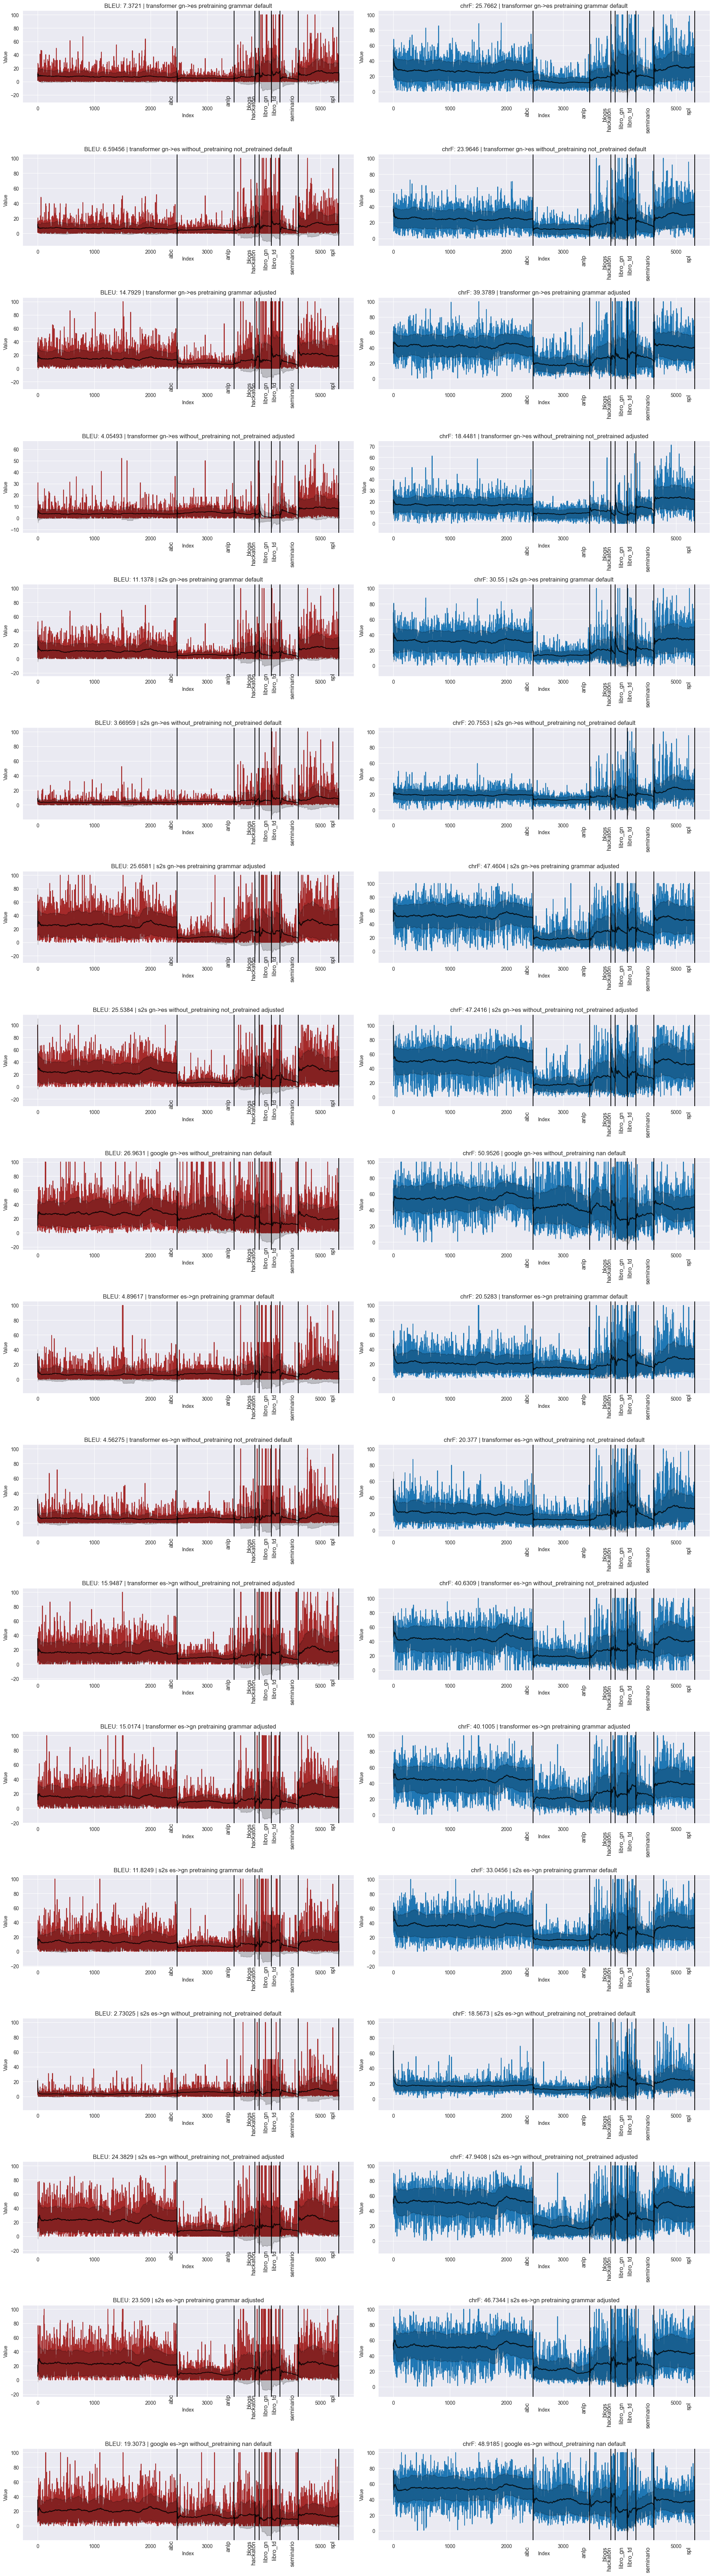

In [225]:
grammar_comparison_df = df[(df['pretraining_corpus']=='grammar') | (df['pretraining_option']=='without_pretraining')]
grammar_comparison_df = grammar_comparison_df.sort_values(by=['source', 
                                                              'architecture', 
                                                              'hyperparameter_tuning_option', 
                                                              'sacrebleu_corpus_bleu'], 
                                                          ascending=False)
plot_individual_metrics(grammar_comparison_df, 
                        source_indices=last_source_indices, 
                        source_names=source_names)

**Google**

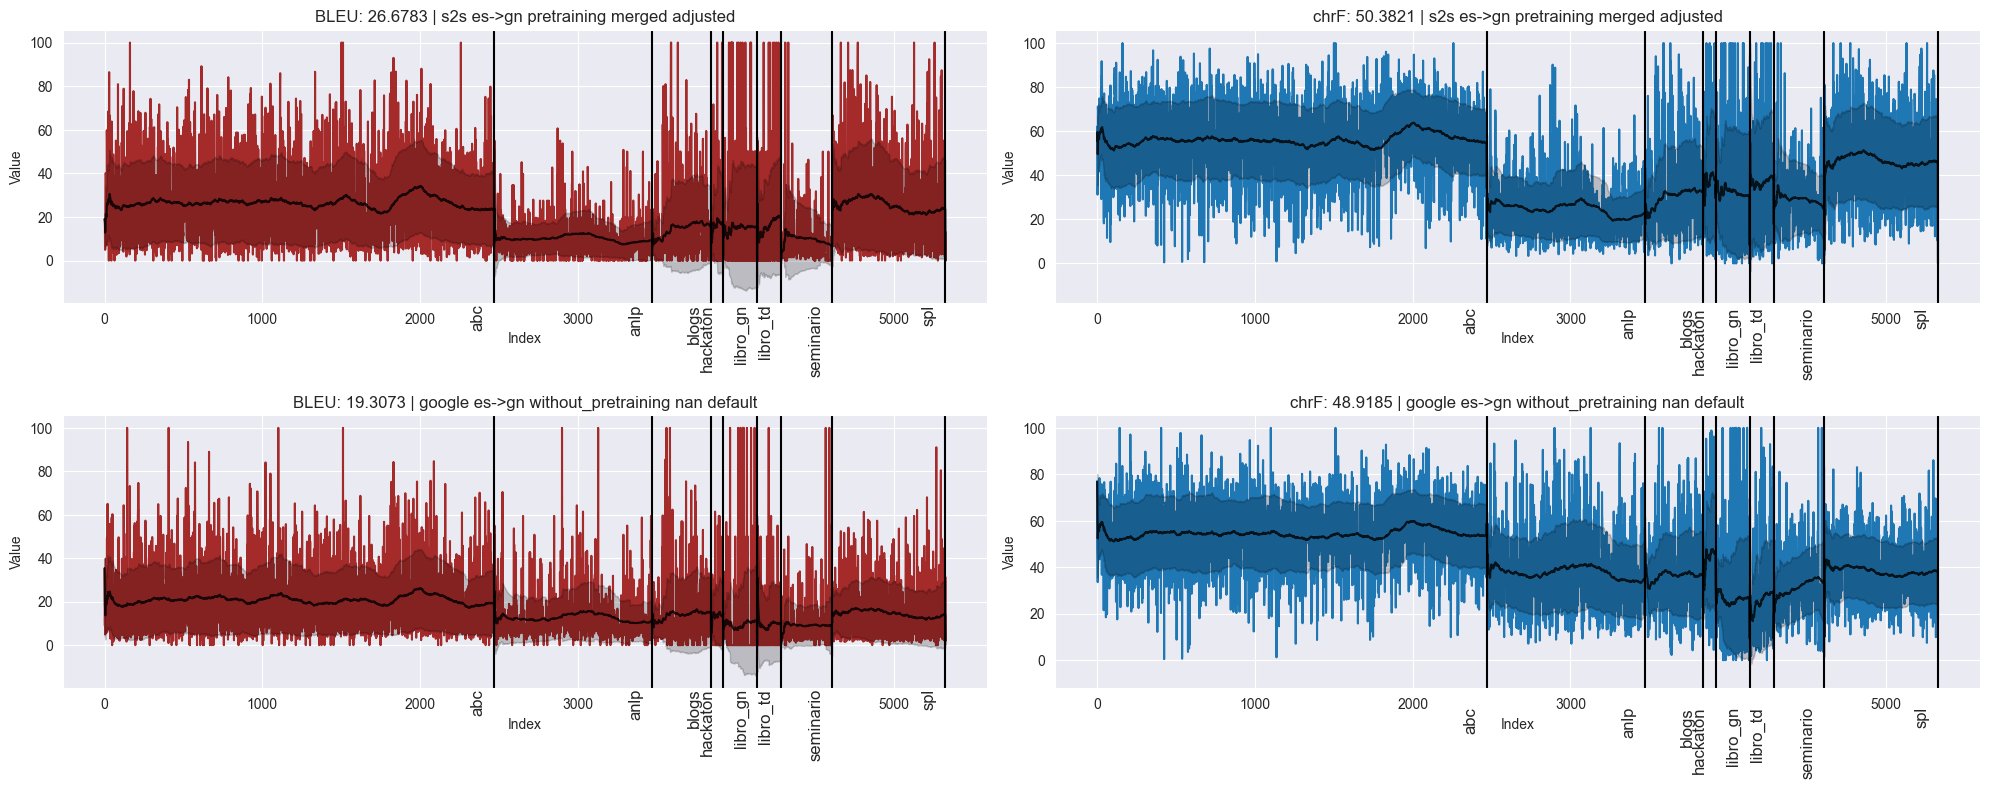

In [224]:
best_dfs = df[((df['sacrebleu_corpus_chrf'] > 50) | (df['architecture']=='google')) & (df['source']=='es')]
plot_individual_metrics(best_dfs, 
                        source_indices=last_source_indices, 
                        source_names=source_names)